<a href="https://colab.research.google.com/github/dipayandas97/Deep-Learning-Notebooks/blob/master/BayesianCNN_NIH_sampleDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from google.colab import drive
import os
import torch

drive.mount('/content/drive/')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


#Dataset

In [2]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from PIL import Image
import csv

datapath = '/content/drive/My Drive/ISI/COVID-19/Bayesian_CNN/NIH_sample_dataset/images/'
labelpath = '/content/drive/My Drive/ISI/COVID-19/Bayesian_CNN/NIH_sample_dataset/sample_labels.csv'
list_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.Grayscale(num_output_channels=3),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[130], std=[63])])

class NIH_sample_dataset(Dataset):
    def __init__(self, datapath, labelpath, transforms=None):
        
        self.datapath = datapath
        self.labelpath = labelpath
        self.transforms = transforms
        self.list_of_labels = [ 'Atelectasis','Cardiomegaly','Effusion','Infiltration','Mass',
                                'Nodule','Pneumonia','Pneumothorax','Consolidation','Edema',
                                'Emphysema', 'Fibrosis','Pleural_Thickening', 'Hernia','No Finding']

        #build list of (name,label) tuples as self.labels
        label_file = pd.read_csv(self.labelpath)
        image_names = label_file['Image Index']
        labels = label_file['Finding Labels']
        self.labels = []
        for i in range(image_names.shape[0]):
            self.labels.append((image_names[i], self.oneHotEncode(labels[i])))
        
    def oneHotEncode(self, label):
        encoded_label = torch.zeros(15)
        for idx,name in enumerate(self.list_of_labels):
            if name in label:
                encoded_label[idx] = 1.
        assert label.count('|')+1 == torch.sum(encoded_label).item()
        return encoded_label

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_name, image_label = self.labels[idx]
        image_path = os.path.join(self.datapath,image_name)
        image = Image.open(open(image_path, 'rb'))

        #apply transforms
        if self.transforms:
            image = self.transforms(image)

        return ((image, image_label))

def get_dataloader(dataset, test_size=0.2, batch_size=32, num_workers=1):    #Expects Dataset class object
    indices = list(range(len(dataset)))
    np.random.shuffle(indices)
    split_idx = int(len(dataset) * test_size)

    train_ids, test_ids = indices[split_idx:], indices[:split_idx]
    train_sampler = SubsetRandomSampler(train_ids)
    test_sampler = SubsetRandomSampler(test_ids)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=num_workers)

    return train_loader, test_loader    

In [4]:
#dataset = NIH_sample_dataset(datapath=datapath, labelpath=labelpath, transforms=list_transforms)
#train_loader, test_loader = get_dataloader(dataset=dataset, test_size=0.2, batch_size=32, num_workers=6)

#Model

In [3]:
import torch
!git clone https://github.com/kumar-shridhar/PyTorch-BayesianCNN

os.chdir('/content/PyTorch-BayesianCNN/')
os.getcwd()

from torch.optim import Adam, lr_scheduler
from torch.nn import functional as F

import data
import utils
import metrics
import config_bayesian as cfg

Cloning into 'PyTorch-BayesianCNN'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 1672 (delta 66), reused 80 (delta 43), pack-reused 1561
Receiving objects: 100% (1672/1672), 67.82 MiB | 20.75 MiB/s, done.
Resolving deltas: 100% (1002/1002), done.


In [4]:
import torch.nn as nn
import math
from layers import BBB_Linear, BBB_Conv2d
from layers import BBB_LRT_Linear, BBB_LRT_Conv2d
from layers import FlattenLayer, ModuleWrapper

class get_model(ModuleWrapper):
    def __init__(self, outputs=2, inputs=3, priors=None, layer_type='lrt', activation_type='relu'):
        super(get_model, self).__init__()

        self.num_classes = outputs
        self.layer_type = layer_type
        self.priors = priors

        if layer_type=='lrt':
            BBBLinear = BBB_LRT_Linear
            BBBConv2d = BBB_LRT_Conv2d
        elif layer_type=='bbb':
            BBBLinear = BBB_Linear
            BBBConv2d = BBB_Conv2d
        else:
            raise ValueError("Undefined layer_type")
        
        if activation_type=='softplus':
            self.act = nn.Softplus
        elif activation_type=='relu':
            self.act = nn.ReLU
        else:
            raise ValueError("Only softplus or relu supported")

        self.conv1 = BBBConv2d(inputs, 64, 5, stride=5, padding=1, bias=True, priors=self.priors)
        self.act1 = self.act()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = BBBConv2d(64, 192, 5, padding=2, bias=True, priors=self.priors)
        self.act2 = self.act()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = BBBConv2d(192, 384, 3, padding=1, bias=True, priors=self.priors)
        self.act3 = self.act()

        self.conv4 = BBBConv2d(384, 256, 3, padding=1, bias=True, priors=self.priors)
        self.act4 = self.act()

        self.conv5 = BBBConv2d(256, 128, 3, padding=1, bias=True, priors=self.priors)
        self.act5 = self.act()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn_1 = nn.BatchNorm2d(128)

        self.conv6 = BBBConv2d(128, 128, 3, padding=1, bias=True, priors=self.priors)
        self.act6 = self.act()

        self.conv7 = BBBConv2d(128, 128, 3, padding=0, bias=True, priors=self.priors)
        self.act7 = self.act()

        self.conv8 = BBBConv2d(128, 128, 3, padding=0, bias=True, priors=self.priors)
        self.act8 = self.act()
        
        self.flatten = FlattenLayer(1 * 1 * 128)

        self.fc1 = BBBLinear(1*1*128, 64, bias=True, priors=self.priors)
        self.act9 = self.act()
        
        self.fc2 = BBBLinear(64, 32, bias=True, priors=self.priors)
        self.act10 = self.act()
        
        self.fc3 = BBBLinear(32, outputs, bias=True, priors=self.priors)
        self.act11 = nn.Sigmoid()

    #def forward_(self,x):
    #    print('Own forward()')
        
model = get_model(outputs=15, inputs=3).to(device)

#Train/Test Routine

In [5]:
#Train routine
from tqdm.notebook import tqdm as tqdm
from sklearn.model_selection import train_test_split

class ELBO(nn.Module):
    def __init__(self, train_size):
        super(ELBO, self).__init__()
        self.train_size = train_size

    def forward(self, input, target, kl, beta):
        assert not target.requires_grad
        loss = nn.BCELoss()
        return loss(input, target) + beta * kl

def acc(outputs, targets):
    #Thresholding : 0.5
    outputs[torch.where(outputs>0.5)] = 1.
    outputs[torch.where(outputs!=1.)] = 0.
    return torch.mean((outputs==targets).float(), dim=0).detach().cpu().numpy()

def train_model(net, dataloader, optimizer, criterion, num_ens=1, beta_type=0.1, epoch=None, num_epochs=None):
    net.train()
    training_loss = 0.0
    accs = []
    kl_list = []

    for i,(X, Y) in tqdm(enumerate(dataloader,1), total=len(dataloader)):

        optimizer.zero_grad()

        inputs, labels = X.to(device), Y.to(device)
        outputs = torch.zeros(X.size(0), net.num_classes).to(device)
        
        net_out, kl = net(inputs)
        outputs[:, :] = net_out

        kl_list.append(kl.item())

        beta = metrics.get_beta(i-1, len(dataloader), beta_type, epoch, num_epochs)
        loss = criterion(outputs, labels, kl, beta)
        loss.backward()
        optimizer.step()

        accs.append(acc(outputs.data, labels.data))
        training_loss += loss.cpu().data.numpy()
    del X, Y
    return training_loss/len(dataloader), np.mean(np.asarray(accs), axis=0), np.mean(kl_list)

def validate_model(net, dataloader, criterion, batch_size = 32, num_ens=1, beta_type=0.1, epoch=None, num_epochs=None):
    net.train()
    valid_loss = 0.0
    accs = []
    kl_list = []

    for i,(X,Y) in tqdm(enumerate(dataloader,1), total=len(dataloader)):
    
        inputs, labels = X.to(device), Y.to(device)
        outputs = torch.zeros(X.size(0), net.num_classes).to(device)

        net_out, kl = net(inputs)
        outputs[:, :] = net_out

        kl_list.append(kl.item())

        beta = metrics.get_beta(i-1, len(dataloader), beta_type, epoch, num_epochs)
        valid_loss += criterion(outputs, labels, kl, beta).item()
        accs.append(acc(outputs, labels))
    
    del X, Y
    return valid_loss/len(dataloader), np.mean(np.asarray(accs), axis=0), np.mean(kl_list)

Epoch : 0 / 500



Train Loss: 128012.15530806738 | Train KL: 1280113.634751773
Train Acc: [0.6273493  0.5055851  0.47491136 0.5174646  0.2897163  0.5339539
 0.47774825 0.7001773  0.5638741  0.7425088  0.7223404  0.36378548
 0.70412236 0.39570037 0.48962766]
Test Loss: 77587.56684027778 | Test KL: 775868.625
Test Acc: [0.5633681  0.5512153  0.49479166 0.484375   0.34288195 0.4809028
 0.5494792  0.6258681  0.4704861  0.7152778  0.6154514  0.20746528
 0.6302083  0.44618055 0.4939236 ]


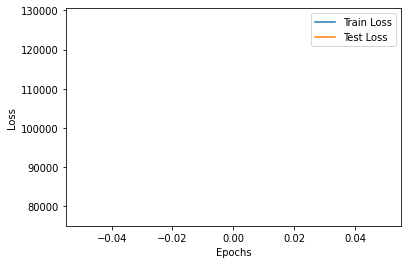

---------------------------------------------------------------------------------
Epoch : 1 / 500



Train Loss: 58641.73226950355 | Train KL: 586410.3344414893
Train Acc: [0.5339539  0.52309394 0.48328903 0.51733154 0.40319148 0.4557624
 0.5425089  0.5809397  0.5091312  0.645656   0.5658688  0.2851064
 0.5768174  0.47468972 0.5127216 ]
Test Loss: 44322.51421440972 | Test KL: 443218.15625
Test Acc: [0.5260417  0.4800347  0.5026042  0.5538194  0.45399305 0.5295139
 0.5737847  0.5225694  0.4904514  0.5946181  0.5329861  0.37760416
 0.5625     0.49305555 0.4826389 ]


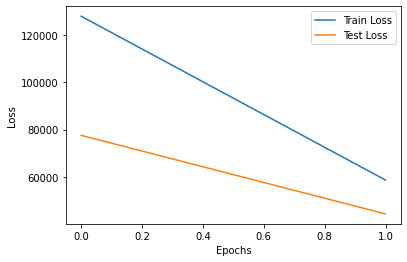

---------------------------------------------------------------------------------
Epoch : 2 / 500



Train Loss: 34873.89022329344 | Train KL: 348731.91223404254
Train Acc: [0.5226507  0.5180408  0.5205231  0.5299645  0.48812056 0.5101064
 0.5514184  0.5402483  0.52672875 0.5760638  0.5263298  0.46484926
 0.53541666 0.5347075  0.49521273]
Test Loss: 26578.704644097223 | Test KL: 265780.03125
Test Acc: [0.5069444 0.5477431 0.5164931 0.5407986 0.5538194 0.5494792 0.5373264
 0.5434028 0.5173611 0.5755208 0.5451389 0.5407986 0.5251736 0.5147569
 0.4565972]


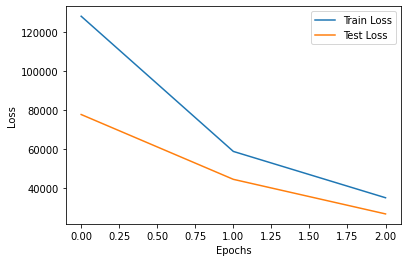

---------------------------------------------------------------------------------
Epoch : 3 / 500



Train Loss: 20344.868891289894 | Train KL: 203441.56172429078
Train Acc: [0.51480496 0.5390514  0.5180851  0.5197695  0.5394947  0.52686167
 0.5391844  0.5253103  0.5509752  0.55062056 0.5318706  0.535328
 0.5356826  0.5253103  0.50700355]
Test Loss: 14848.359890407986 | Test KL: 148476.359375
Test Acc: [0.5303819 0.5633681 0.4826389 0.5321181 0.5329861 0.5138889 0.5633681
 0.5538194 0.5642361 0.5677083 0.5130208 0.5581597 0.5512153 0.53125
 0.4965278]


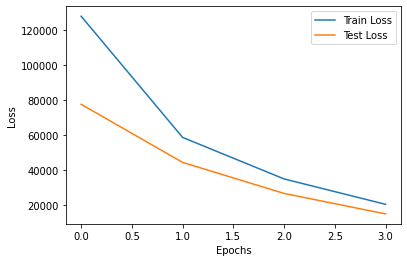

---------------------------------------------------------------------------------
Epoch : 4 / 500



Train Loss: 10871.890815464318 | Train KL: 108711.48897384752
Train Acc: [0.52828014 0.5474734  0.5301862  0.5329787  0.541844   0.53164893
 0.5506649  0.53794324 0.5511082  0.5529255  0.5320922  0.54268616
 0.5361702  0.5410904  0.50159574]
Test Loss: 7478.692030164931 | Test KL: 74779.3046875
Test Acc: [0.5625     0.5642361  0.5329861  0.49739584 0.5069444  0.5651042
 0.5425347  0.5095486  0.5251736  0.5199653  0.5208333  0.5381944
 0.5520833  0.5920139  0.5321181 ]


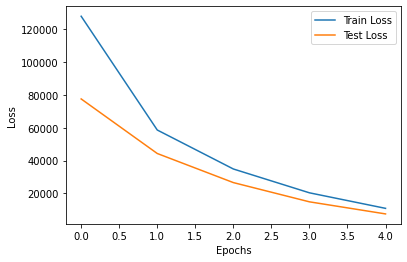

---------------------------------------------------------------------------------
Epoch : 5 / 500



Train Loss: 5207.0592188192595 | Train KL: 52062.88777149823
Train Acc: [0.5320922  0.5546986  0.53541666 0.52575356 0.5448138  0.5335106
 0.55713654 0.5363032  0.5481826  0.54539007 0.5340869  0.5445922
 0.5493351  0.55279255 0.5133422 ]
Test Loss: 3349.265190972222 | Test KL: 33484.92578125
Test Acc: [0.5625     0.5182292  0.5190972  0.48524305 0.5616319  0.5251736
 0.5503472  0.5555556  0.5190972  0.5503472  0.5329861  0.5607639
 0.5755208  0.5355903  0.4939236 ]


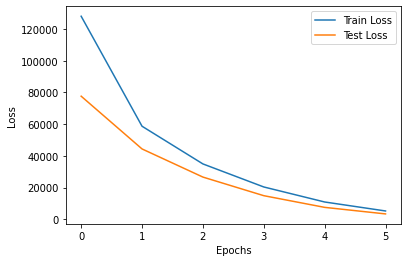

---------------------------------------------------------------------------------
Epoch : 6 / 500



Train Loss: 2212.6012984471963 | Train KL: 22118.311384917997
Train Acc: [0.52610815 0.5406028  0.52477837 0.51710993 0.5390514  0.54499114
 0.55070925 0.5484486  0.53226954 0.54867023 0.5388741  0.54064715
 0.5453458  0.5512411  0.5005319 ]
Test Loss: 1324.7005683051216 | Test KL: 13239.4541015625
Test Acc: [0.5173611 0.546875  0.53125   0.5217014 0.5295139 0.5434028 0.5434028
 0.5277778 0.5625    0.5329861 0.5390625 0.5616319 0.5173611 0.5130208
 0.5069444]


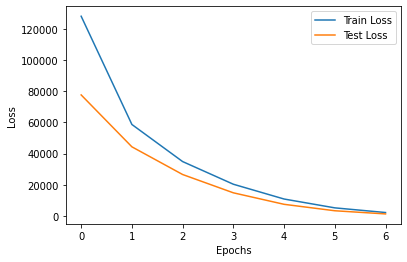

---------------------------------------------------------------------------------
Epoch : 7 / 500



Train Loss: 830.4684972019061 | Train KL: 8297.265070921985
Train Acc: [0.53195924 0.5277482  0.5185727  0.512367   0.53736705 0.5339982
 0.5351507  0.52220744 0.539273   0.5328014  0.5336436  0.51870567
 0.54738474 0.54574466 0.49720743]
Test Loss: 461.9487296210395 | Test KL: 4612.228515625
Test Acc: [0.49479166 0.5329861  0.5034722  0.5078125  0.5164931  0.5295139
 0.5104167  0.5364583  0.5642361  0.5243056  0.5520833  0.515625
 0.5399306  0.5512153  0.49479166]


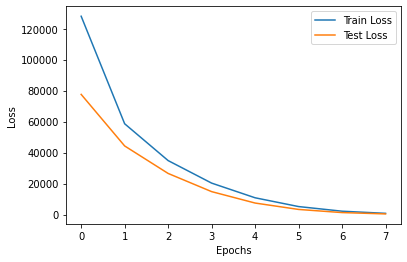

---------------------------------------------------------------------------------
Epoch : 8 / 500



Train Loss: 275.37653269666305 | Train KL: 2746.6434568581008
Train Acc: [0.5089096  0.5239805  0.51090425 0.50447696 0.5035904  0.51480496
 0.51990247 0.5156472  0.5148936  0.5167996  0.5172429  0.5442376
 0.52424645 0.52101064 0.49250886]
Test Loss: 142.44720331827799 | Test KL: 1417.409423828125
Test Acc: [0.5086806  0.5095486  0.4609375  0.4748264  0.5121528  0.5086806
 0.4956597  0.47569445 0.5052083  0.48524305 0.5121528  0.4956597
 0.5217014  0.48958334 0.47743055]


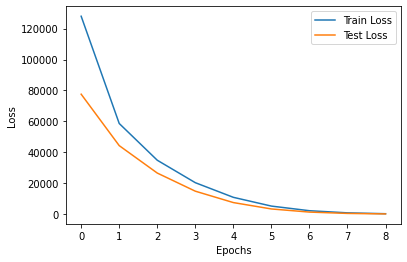

---------------------------------------------------------------------------------
Epoch : 9 / 500



Train Loss: 81.091038751264 | Train KL: 803.9332751551418
Train Acc: [0.51134753 0.50159574 0.51427305 0.4927748  0.51733154 0.51688826
 0.50948584 0.51427305 0.5070479  0.51462764 0.5140071  0.5135195
 0.510461   0.5111702  0.49605495]
Test Loss: 39.23922602335612 | Test KL: 385.4264221191406
Test Acc: [0.4982639  0.49739584 0.5164931  0.48958334 0.5425347  0.4956597
 0.5095486  0.5        0.5390625  0.5260417  0.5104167  0.49131945
 0.5303819  0.4861111  0.484375  ]


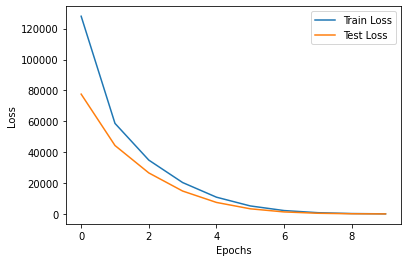

---------------------------------------------------------------------------------
Epoch : 10 / 500



Train Loss: 21.567495697779012 | Train KL: 208.72999588986661
Train Acc: [0.49552307 0.52610815 0.5027926  0.50110817 0.5085993  0.51427305
 0.5153369  0.5150266  0.50678194 0.5121011  0.5189717  0.5199468
 0.5001773  0.5239805  0.508555  ]
Test Loss: 10.001491811540392 | Test KL: 93.06642150878906
Test Acc: [0.5260417  0.4878472  0.5173611  0.46614584 0.5069444  0.4704861
 0.5190972  0.5277778  0.4887153  0.5243056  0.4652778  0.4965278
 0.5269097  0.5416667  0.5234375 ]


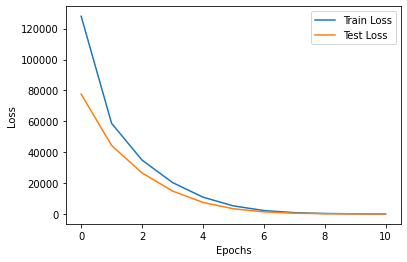

---------------------------------------------------------------------------------
Epoch : 11 / 500



Train Loss: 5.518810136943844 | Train KL: 48.244713992937236
Train Acc: [0.5178635  0.51223403 0.51254433 0.49348405 0.50398934 0.51325357
 0.51436174 0.5223404  0.5050532  0.5065159  0.50735813 0.51631206
 0.5155585  0.5121454  0.49751773]
Test Loss: 2.6980666319529214 | Test KL: 20.038585662841797
Test Acc: [0.48958334 0.5095486  0.4921875  0.5086806  0.5095486  0.5425347
 0.49479166 0.5286458  0.5286458  0.53125    0.4939236  0.4921875
 0.5069444  0.46788195 0.5095486 ]


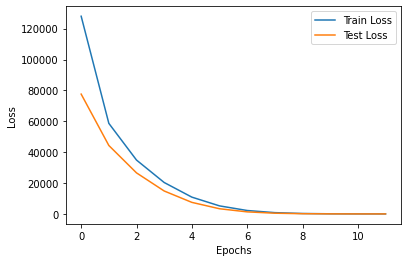

---------------------------------------------------------------------------------
Epoch : 12 / 500



Train Loss: 1.692339838819301 | Train KL: 9.980519411411692
Train Acc: [0.5131649  0.5100177  0.49281916 0.51458335 0.5113918  0.51134753
 0.5261968  0.5027039  0.51054966 0.51812947 0.5222517  0.5091312
 0.50616133 0.5167996  0.49942374]
Test Loss: 1.0824929806921217 | Test KL: 3.8878331184387207
Test Acc: [0.5060764  0.5373264  0.4921875  0.5173611  0.5217014  0.5260417
 0.5434028  0.48958334 0.4782986  0.5182292  0.5147569  0.5338542
 0.5251736  0.5286458  0.49739584]


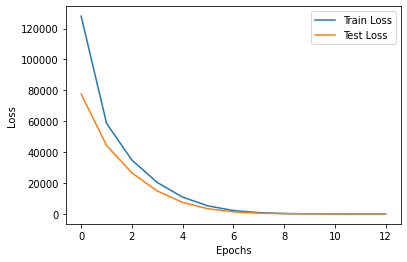

---------------------------------------------------------------------------------
Epoch : 13 / 500



Train Loss: 0.8839530247323056 | Train KL: 1.8908450603485107
Train Acc: [0.4985816  0.5032358  0.5050532  0.49818262 0.50806737 0.49906915
 0.51312053 0.5221188  0.51644504 0.51480496 0.50753546 0.514539
 0.506383   0.51325357 0.506383  ]
Test Loss: 0.7690246568785774 | Test KL: 0.7339849472045898
Test Acc: [0.4722222  0.5086806  0.5026042  0.5138889  0.515625   0.4878472
 0.47395834 0.5217014  0.4956597  0.4809028  0.49131945 0.49131945
 0.5225694  0.5217014  0.4878472 ]


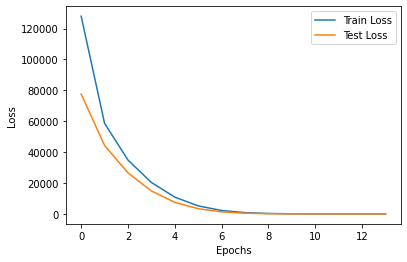

---------------------------------------------------------------------------------
Epoch : 14 / 500



Train Loss: 0.7320760657601323 | Train KL: 0.37513321870607685
Train Acc: [0.50669324 0.5189273  0.50070924 0.5035018  0.5134309  0.5219858
 0.50882095 0.52030146 0.50536346 0.5119238  0.5049202  0.49720743
 0.5027039  0.52508867 0.50815606]
Test Loss: 0.7125157846344842 | Test KL: 0.17233982682228088
Test Acc: [0.5173611  0.5416667  0.49305555 0.5321181  0.4887153  0.49305555
 0.48177084 0.5138889  0.4878472  0.49739584 0.5217014  0.5251736
 0.5095486  0.5269097  0.48958334]


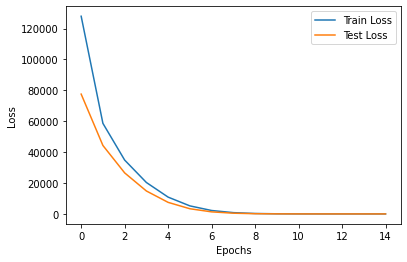

---------------------------------------------------------------------------------
Epoch : 15 / 500



Train Loss: 0.7066615857976548 | Train KL: 0.12337758027492686
Train Acc: [0.5185284  0.50616133 0.5068263  0.5014184  0.49543437 0.5120567
 0.5153369  0.5081117  0.51187944 0.5005319  0.5155585  0.5111702
 0.514539   0.51134753 0.5078901 ]
Test Loss: 0.7040244986613592 | Test KL: 0.08624587208032608
Test Acc: [0.48524305 0.5130208  0.484375   0.484375   0.4956597  0.5104167
 0.4956597  0.5303819  0.4956597  0.4809028  0.5234375  0.5104167
 0.48958334 0.5086806  0.453125  ]


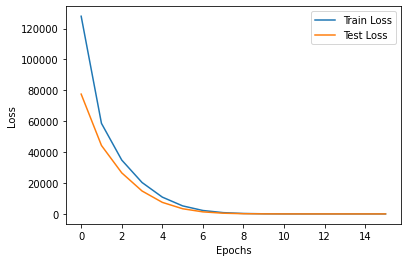

---------------------------------------------------------------------------------
Epoch : 16 / 500



Train Loss: 0.6998602802871813 | Train KL: 0.056834677643809756
Train Acc: [0.4991578  0.5078457  0.5068263  0.50602835 0.52318263 0.5057181
 0.51294327 0.51325357 0.50624996 0.50580674 0.5214539  0.50815606
 0.5033688  0.5170213  0.50460994]
Test Loss: 0.699829078382916 | Test KL: 0.05848155915737152
Test Acc: [0.5399306  0.4644097  0.515625   0.49305555 0.5104167  0.49739584
 0.49913195 0.49739584 0.5104167  0.5078125  0.5494792  0.5321181
 0.5234375  0.5234375  0.5       ]


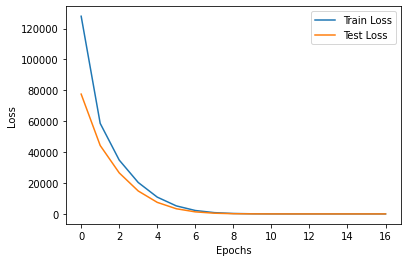

---------------------------------------------------------------------------------
Epoch : 17 / 500



Train Loss: 0.7006951946738764 | Train KL: 0.05960575028831232
Train Acc: [0.49499112 0.5046542  0.50474286 0.5092642  0.50115246 0.50970745
 0.5132092  0.5050532  0.50815606 0.51312053 0.510594   0.51613474
 0.51090425 0.51675534 0.49485818]
Test Loss: 0.7003471338086658 | Test KL: 0.0536159873008728
Test Acc: [0.5121528 0.5277778 0.5190972 0.4765625 0.5060764 0.4592014 0.5434028
 0.5364583 0.4904514 0.5095486 0.5060764 0.5       0.5329861 0.5026042
 0.4956597]


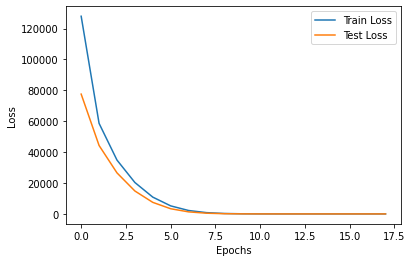

---------------------------------------------------------------------------------
Epoch : 18 / 500



Train Loss: 0.7006059272069458 | Train KL: 0.06393956511895707
Train Acc: [0.5177748  0.51600176 0.50372344 0.5033688  0.5185727  0.5059397
 0.510461   0.52491134 0.49472517 0.5082447  0.5155585  0.51165783
 0.5107713  0.50882095 0.4964096 ]
Test Loss: 0.7020473430554072 | Test KL: 0.0760212242603302
Test Acc: [0.48697916 0.5008681  0.4487847  0.5182292  0.4982639  0.5199653
 0.49913195 0.5564236  0.5190972  0.5095486  0.49739584 0.5434028
 0.5        0.5251736  0.5234375 ]


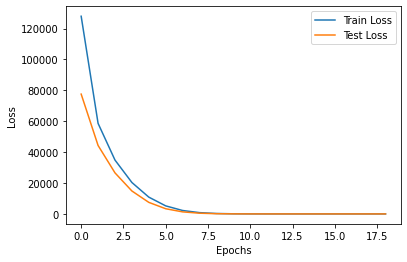

---------------------------------------------------------------------------------
Epoch : 19 / 500



Train Loss: 0.7013502104062561 | Train KL: 0.06806201884087096
Train Acc: [0.5147607  0.497961   0.5108156  0.5089096  0.5178191  0.5195479
 0.51391846 0.499867   0.50540775 0.5091312  0.50031024 0.51981384
 0.51471627 0.50633866 0.48732272]
Test Loss: 0.7008405990070767 | Test KL: 0.06809670478105545
Test Acc: [0.4982639  0.49131945 0.5217014  0.5225694  0.49913195 0.5052083
 0.5008681  0.48350695 0.5381944  0.49913195 0.5251736  0.5017361
 0.5199653  0.5555556  0.5060764 ]


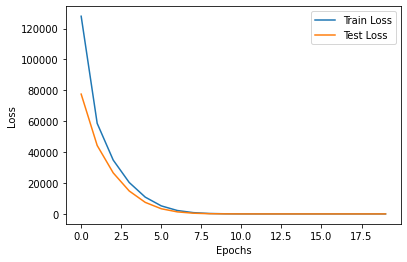

---------------------------------------------------------------------------------
Epoch : 20 / 500



Train Loss: 0.7014814099521501 | Train KL: 0.07030215325719076
Train Acc: [0.51134753 0.51631206 0.52109927 0.5007535  0.5121011  0.51241136
 0.52070034 0.4991578  0.5136525  0.5193262  0.5097961  0.5034575
 0.50328016 0.51653373 0.48998228]
Test Loss: 0.7023051993714439 | Test KL: 0.0716196596622467
Test Acc: [0.48958334 0.5112847  0.4800347  0.5147569  0.4887153  0.5225694
 0.48697916 0.5164931  0.5251736  0.5260417  0.515625   0.5251736
 0.5017361  0.5295139  0.5008681 ]


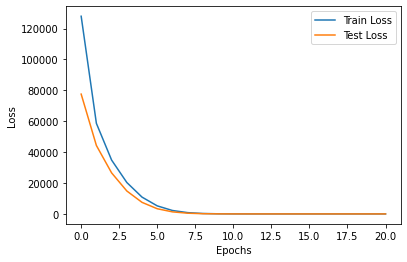

---------------------------------------------------------------------------------
Epoch : 21 / 500



Train Loss: 0.7017243094478093 | Train KL: 0.07166678231235937
Train Acc: [0.50031024 0.5180408  0.51812947 0.4966312  0.51653373 0.51103723
 0.5234486  0.50691485 0.49321806 0.5144504  0.5127216  0.5143174
 0.5143174  0.49875885 0.5100177 ]
Test Loss: 0.7019084244966507 | Test KL: 0.07241534441709518
Test Acc: [0.48177084 0.5130208  0.5112847  0.4904514  0.484375   0.5052083
 0.47569445 0.5121528  0.5043403  0.5529514  0.5295139  0.5060764
 0.5225694  0.5043403  0.5494792 ]


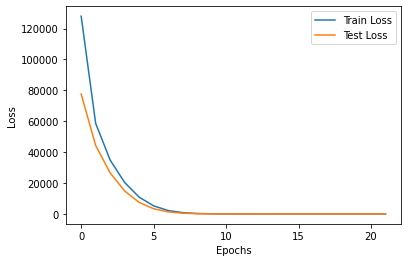

---------------------------------------------------------------------------------
Epoch : 22 / 500



Train Loss: 0.7016944111661708 | Train KL: 0.07252807381516653
Train Acc: [0.5075798  0.5039007  0.5071365  0.5029255  0.50518614 0.5067376
 0.48905143 0.512367   0.5134752  0.50700355 0.5137854  0.5106383
 0.52154255 0.5201684  0.49951243]
Test Loss: 0.7019150621361203 | Test KL: 0.0728120505809784
Test Acc: [0.4921875  0.48958334 0.5277778  0.5164931  0.5598958  0.46788195
 0.48697916 0.5225694  0.47135416 0.5225694  0.5217014  0.5329861
 0.4965278  0.5173611  0.5208333 ]


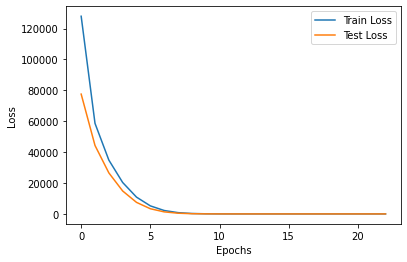

---------------------------------------------------------------------------------
Epoch : 23 / 500



Epoch    24: reducing learning rate of group 0 to 5.0000e-04.
Train Loss: 0.7014404252065835 | Train KL: 0.07155271360637448
Train Acc: [0.5163564  0.50948584 0.49937943 0.5070479  0.5035904  0.5137854
 0.5134752  0.518484   0.510594   0.52087766 0.50514185 0.53435284
 0.51382977 0.5128103  0.49995568]
Test Loss: 0.7013488196664386 | Test KL: 0.0700303241610527
Test Acc: [0.4904514  0.5460069  0.5355903  0.4939236  0.4939236  0.5034722
 0.5486111  0.5069444  0.5373264  0.49131945 0.4782986  0.546875
 0.5269097  0.5008681  0.4748264 ]


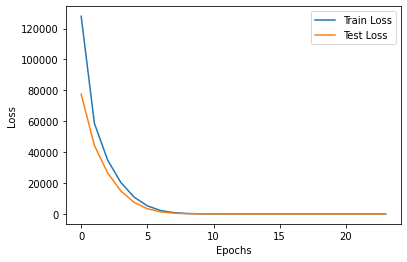

---------------------------------------------------------------------------------
Epoch : 24 / 500



Train Loss: 0.7011026621710325 | Train KL: 0.06818153635195806
Train Acc: [0.5062943  0.5197695  0.5093528  0.5153369  0.5170213  0.5074025
 0.51179075 0.5010638  0.50460994 0.5083333  0.510461   0.51666665
 0.5070479  0.5189717  0.50589544]
Test Loss: 0.7013046691815058 | Test KL: 0.06811130046844482
Test Acc: [0.5078125  0.5026042  0.5060764  0.5199653  0.5208333  0.53125
 0.5243056  0.46180555 0.49913195 0.48524305 0.5078125  0.49739584
 0.5190972  0.5043403  0.5529514 ]


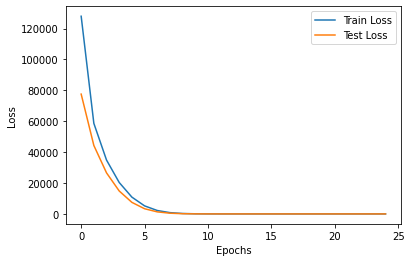

---------------------------------------------------------------------------------
Epoch : 25 / 500



Train Loss: 0.7018784457910145 | Train KL: 0.06813834005213798
Train Acc: [0.5025266  0.514539   0.5006206  0.5091312  0.5025266  0.50243795
 0.5078014  0.4949468  0.5184397  0.5172429  0.50039893 0.50549644
 0.49973404 0.51090425 0.5010638 ]
Test Loss: 0.7015725125869116 | Test KL: 0.06748250871896744
Test Acc: [0.48177084 0.5130208  0.5086806  0.5303819  0.5043403  0.5338542
 0.5147569  0.5182292  0.5225694  0.5112847  0.5095486  0.4730903
 0.5060764  0.4982639  0.5329861 ]


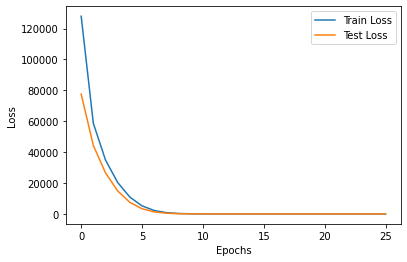

---------------------------------------------------------------------------------
Epoch : 26 / 500



Train Loss: 0.7008969344145862 | Train KL: 0.06800608194254815
Train Acc: [0.5114805  0.5219858  0.5074468  0.506383   0.4956117  0.5130319
 0.52761525 0.50886524 0.5086879  0.52118796 0.49383864 0.5167996
 0.5144504  0.51312053 0.51538116]
Test Loss: 0.7007694807317522 | Test KL: 0.06738366931676865
Test Acc: [0.4904514 0.5130208 0.5217014 0.4956597 0.5338542 0.515625  0.5138889
 0.5217014 0.5       0.5208333 0.5425347 0.515625  0.4904514 0.5069444
 0.5069444]


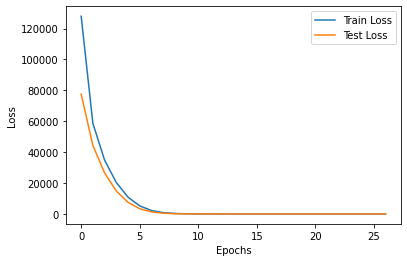

---------------------------------------------------------------------------------
Epoch : 27 / 500



Train Loss: 0.7014308449224378 | Train KL: 0.06808387440569857
Train Acc: [0.5235372  0.5126773  0.5095745  0.49871454 0.50580674 0.5148936
 0.5014184  0.51879436 0.49685284 0.5169326  0.4964096  0.51830673
 0.49618796 0.5271276  0.50101954]
Test Loss: 0.7033988104926215 | Test KL: 0.06816312670707703
Test Acc: [0.5        0.4644097  0.4782986  0.48350695 0.5121528  0.5269097
 0.49739584 0.5182292  0.48697916 0.5199653  0.5390625  0.4722222
 0.5390625  0.4939236  0.484375  ]


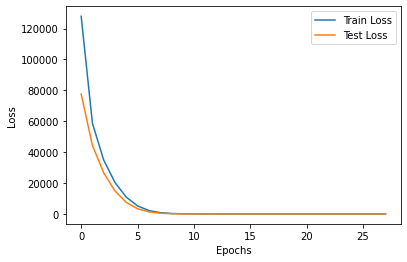

---------------------------------------------------------------------------------
Epoch : 28 / 500



Train Loss: 0.7015344356814175 | Train KL: 0.06808143357435863
Train Acc: [0.5031915  0.5083333  0.5138741  0.51015073 0.4992908  0.51187944
 0.5225621  0.506383   0.5134309  0.5068263  0.50669324 0.506383
 0.5159131  0.5050532  0.49552307]
Test Loss: 0.7010421968168683 | Test KL: 0.06801708042621613
Test Acc: [0.5078125  0.4626736  0.5130208  0.4861111  0.5112847  0.49913195
 0.5208333  0.49913195 0.5277778  0.47743055 0.5086806  0.5217014
 0.5173611  0.48958334 0.4904514 ]


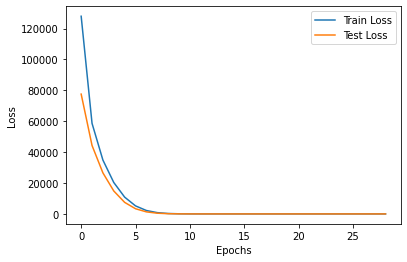

---------------------------------------------------------------------------------
Epoch : 29 / 500



Train Loss: 0.7011208170694663 | Train KL: 0.06814928421526091
Train Acc: [0.51054966 0.5162677  0.5019504  0.5046986  0.50700355 0.516578
 0.5140958  0.5134752  0.5026153  0.51285464 0.5079344  0.50948584
 0.5149823  0.5134752  0.5078901 ]
Test Loss: 0.7000900540086958 | Test KL: 0.06817971169948578
Test Acc: [0.5112847  0.5147569  0.5017361  0.4782986  0.4982639  0.5243056
 0.5295139  0.5078125  0.49131945 0.5416667  0.5130208  0.5130208
 0.4956597  0.5373264  0.5052083 ]


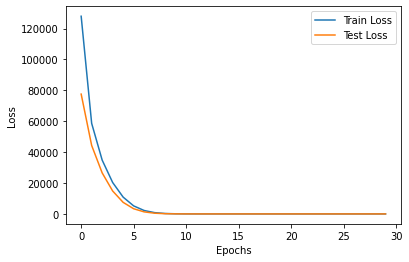

---------------------------------------------------------------------------------
Epoch : 30 / 500



Epoch    31: reducing learning rate of group 0 to 2.5000e-04.
Train Loss: 0.701156404846949 | Train KL: 0.06816396904541246
Train Acc: [0.5291667  0.50540775 0.5106383  0.50589544 0.5247341  0.50460994
 0.51546985 0.51578015 0.51121455 0.5010638  0.51578015 0.50611705
 0.49685284 0.50031024 0.48834217]
Test Loss: 0.7008612867858675 | Test KL: 0.06796523928642273
Test Acc: [0.5060764 0.5269097 0.5225694 0.5164931 0.5078125 0.4904514 0.5295139
 0.4748264 0.4982639 0.5243056 0.5043403 0.5277778 0.5338542 0.4887153
 0.5095486]


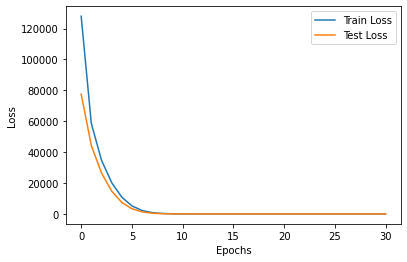

---------------------------------------------------------------------------------
Epoch : 31 / 500



Train Loss: 0.7009828589486737 | Train KL: 0.06807082326065564
Train Acc: [0.51143616 0.5011968  0.5077128  0.4986259  0.5040337  0.52034575
 0.51462764 0.51875    0.5120567  0.5219415  0.49787232 0.5198582
 0.5091312  0.502305   0.49609926]
Test Loss: 0.7022687693436941 | Test KL: 0.06797308474779129
Test Acc: [0.4887153  0.5086806  0.5138889  0.5329861  0.4878472  0.5164931
 0.4887153  0.5269097  0.4809028  0.5234375  0.49479166 0.49479166
 0.5        0.5138889  0.5147569 ]


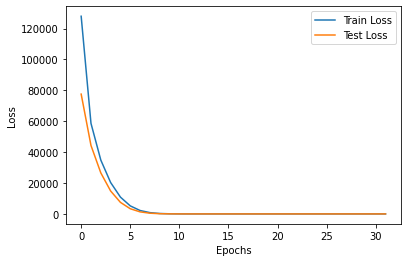

---------------------------------------------------------------------------------
Epoch : 32 / 500



Train Loss: 0.7009405675509297 | Train KL: 0.06799369358213235
Train Acc: [0.5092199  0.512367   0.5032358  0.51054966 0.51511526 0.49818262
 0.50079787 0.50624996 0.5105053  0.51990247 0.5218972  0.51360816
 0.51524824 0.52500004 0.48878545]
Test Loss: 0.7008400311072668 | Test KL: 0.06844600290060043
Test Acc: [0.4861111  0.5234375  0.4826389  0.5295139  0.484375   0.5338542
 0.5295139  0.5086806  0.49305555 0.5008681  0.5008681  0.5243056
 0.5164931  0.5295139  0.5173611 ]


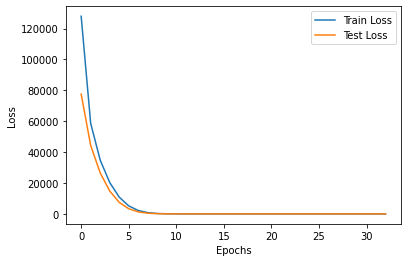

---------------------------------------------------------------------------------
Epoch : 33 / 500



Train Loss: 0.7016099036162626 | Train KL: 0.06813778643701093
Train Acc: [0.5112589  0.5137854  0.49463654 0.5072252  0.5022606  0.510594
 0.5128103  0.5078014  0.50961876 0.5191933  0.50048757 0.5117021
 0.50882095 0.50101954 0.4927748 ]
Test Loss: 0.7017143368721008 | Test KL: 0.0681455135345459
Test Acc: [0.5190972  0.48958334 0.5243056  0.4939236  0.5164931  0.5112847
 0.49739584 0.48697916 0.5277778  0.5277778  0.5017361  0.5347222
 0.5303819  0.5095486  0.4765625 ]


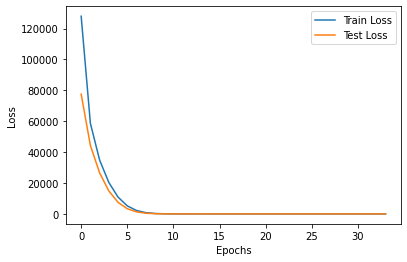

---------------------------------------------------------------------------------
Epoch : 34 / 500



Train Loss: 0.7014530017866311 | Train KL: 0.06808802395636308
Train Acc: [0.510594   0.528945   0.4966312  0.50429964 0.5040337  0.5091312
 0.5066046  0.5078901  0.5227394  0.5178635  0.52087766 0.50970745
 0.512367   0.49840426 0.4984929 ]
Test Loss: 0.7015819549560547 | Test KL: 0.06787019968032837
Test Acc: [0.5295139  0.5251736  0.48697916 0.4704861  0.484375   0.5147569
 0.5277778  0.5277778  0.4904514  0.4965278  0.5112847  0.5121528
 0.47743055 0.5095486  0.5008681 ]


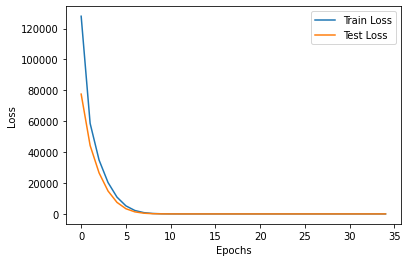

---------------------------------------------------------------------------------
Epoch : 35 / 500



Train Loss: 0.7013416078919215 | Train KL: 0.06806113798144861
Train Acc: [0.5117021  0.5093528  0.5012855  0.5028369  0.50438833 0.51414007
 0.5075798  0.5083777  0.51382977 0.512367   0.5130319  0.5107269
 0.5070479  0.51546985 0.50545216]
Test Loss: 0.702397980623775 | Test KL: 0.06778919696807861
Test Acc: [0.5017361  0.47569445 0.4861111  0.515625   0.4982639  0.5260417
 0.5069444  0.4939236  0.46961805 0.5295139  0.5086806  0.5364583
 0.5069444  0.4878472  0.4921875 ]


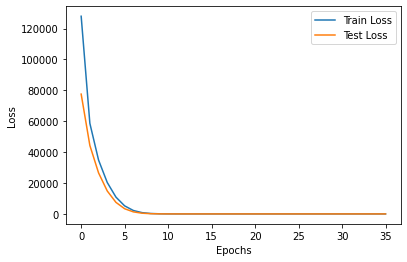

---------------------------------------------------------------------------------
Epoch : 36 / 500



Train Loss: 0.7008779898602912 | Train KL: 0.06803785222219237
Train Acc: [0.51414007 0.5226507  0.5050532  0.49530143 0.51493794 0.5204344
 0.50966316 0.50416666 0.51582444 0.51103723 0.5140071  0.512367
 0.50691485 0.5020833  0.514672  ]
Test Loss: 0.7008442083994547 | Test KL: 0.068081796169281
Test Acc: [0.49305555 0.5173611  0.5095486  0.5338542  0.5043403  0.5225694
 0.4887153  0.5121528  0.5329861  0.5112847  0.48958334 0.484375
 0.4861111  0.5199653  0.5182292 ]


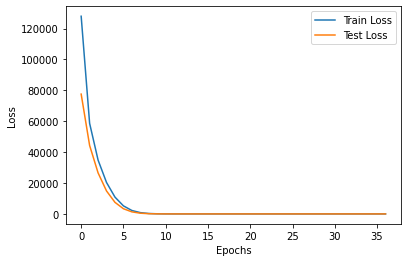

---------------------------------------------------------------------------------
Epoch : 37 / 500



Epoch    38: reducing learning rate of group 0 to 1.2500e-04.
Train Loss: 0.701218325618311 | Train KL: 0.06808657854372728
Train Acc: [0.49605495 0.51799643 0.5094415  0.5076241  0.49787232 0.514672
 0.52309394 0.4971188  0.5140071  0.50624996 0.514672   0.5062943
 0.50669324 0.52021277 0.5006206 ]
Test Loss: 0.7001904861794578 | Test KL: 0.06758979707956314
Test Acc: [0.5572917  0.5217014  0.4982639  0.5199653  0.4904514  0.5425347
 0.5338542  0.5208333  0.4982639  0.5173611  0.5269097  0.46961805
 0.5164931  0.5208333  0.48697916]


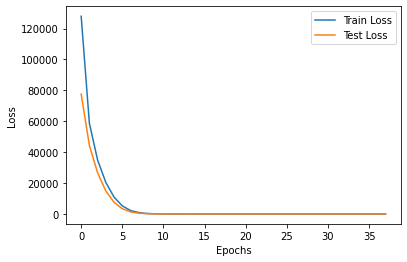

---------------------------------------------------------------------------------
Epoch : 38 / 500



Train Loss: 0.7019582213239467 | Train KL: 0.06803512383014598
Train Acc: [0.5172429  0.5117021  0.5000443  0.50585103 0.5006206  0.52087766
 0.5039007  0.497828   0.51325357 0.5097961  0.5195479  0.5092199
 0.5038121  0.5038121  0.4820479 ]
Test Loss: 0.700898559557067 | Test KL: 0.06815307587385178
Test Acc: [0.5269097  0.48350695 0.5338542  0.49739584 0.5060764  0.5347222
 0.5425347  0.5190972  0.4956597  0.5260417  0.5078125  0.5112847
 0.484375   0.5234375  0.4982639 ]


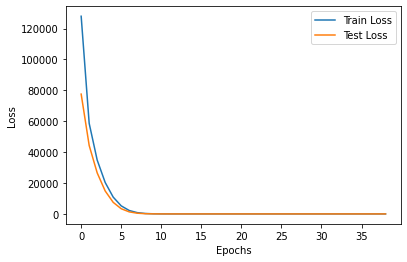

---------------------------------------------------------------------------------
Epoch : 39 / 500



Train Loss: 0.7012656555108144 | Train KL: 0.06804626921178601
Train Acc: [0.50611705 0.52101064 0.5090869  0.51710993 0.5205231  0.5097961
 0.51631206 0.49960107 0.51644504 0.51511526 0.524867   0.5026153
 0.50048757 0.51414007 0.502039  ]
Test Loss: 0.699031467239062 | Test KL: 0.06809987872838974
Test Acc: [0.5451389  0.5269097  0.5251736  0.5399306  0.5381944  0.48958334
 0.5121528  0.5338542  0.5034722  0.5086806  0.5147569  0.5460069
 0.5269097  0.5381944  0.5095486 ]


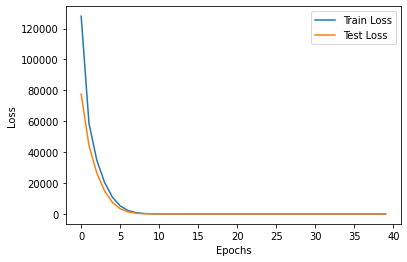

---------------------------------------------------------------------------------
Epoch : 40 / 500



Train Loss: 0.7009870896102689 | Train KL: 0.0680598776179848
Train Acc: [0.49964538 0.5128103  0.5179078  0.49618796 0.5012855  0.4985372
 0.5220301  0.51653373 0.5014184  0.50602835 0.50523055 0.52358156
 0.51325357 0.51068264 0.5022606 ]
Test Loss: 0.702355146408081 | Test KL: 0.06780929863452911
Test Acc: [0.4809028  0.4765625  0.49479166 0.47395834 0.4878472  0.5182292
 0.5060764  0.49305555 0.4887153  0.4939236  0.4939236  0.5321181
 0.5121528  0.5373264  0.48697916]


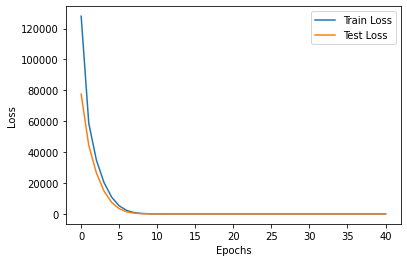

---------------------------------------------------------------------------------
Epoch : 41 / 500



Train Loss: 0.7011030540398672 | Train KL: 0.06801808773414462
Train Acc: [0.5068263  0.5092642  0.50616133 0.5071365  0.50948584 0.5083777
 0.5163564  0.5065159  0.5057181  0.5335106  0.5136968  0.5078901
 0.5126773  0.52588654 0.49618796]
Test Loss: 0.7017749415503608 | Test KL: 0.06794323027133942
Test Acc: [0.48524305 0.48177084 0.484375   0.5069444  0.5147569  0.5260417
 0.4904514  0.5251736  0.5017361  0.5442708  0.5373264  0.5026042
 0.49305555 0.5251736  0.4904514 ]


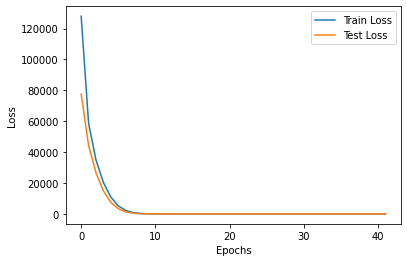

---------------------------------------------------------------------------------
Epoch : 42 / 500



Train Loss: 0.7011426471649332 | Train KL: 0.06804356200897947
Train Acc: [0.50580674 0.5095745  0.51006204 0.5114805  0.5134752  0.51812947
 0.50970745 0.5121011  0.5150266  0.50815606 0.51812947 0.51733154
 0.50624996 0.5159131  0.49809396]
Test Loss: 0.7017001360654831 | Test KL: 0.0680014118552208
Test Acc: [0.5182292  0.46961805 0.5277778  0.4878472  0.5321181  0.5173611
 0.4878472  0.5243056  0.5208333  0.5486111  0.5034722  0.5
 0.5217014  0.47395834 0.47395834]


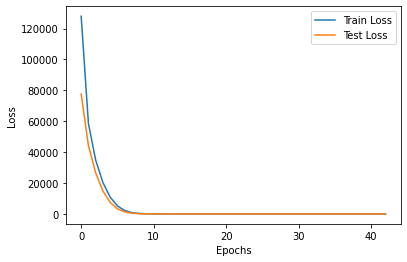

---------------------------------------------------------------------------------
Epoch : 43 / 500



Train Loss: 0.7017531974095825 | Train KL: 0.06807592067312687
Train Acc: [0.508555   0.5140071  0.50478727 0.5044326  0.51037234 0.50589544
 0.50124115 0.5172429  0.512766   0.50647163 0.5092642  0.50474286
 0.5070479  0.50159574 0.49893615]
Test Loss: 0.7013167788585027 | Test KL: 0.06787500530481339
Test Acc: [0.4878472  0.5034722  0.4956597  0.5008681  0.48177084 0.5460069
 0.5364583  0.5416667  0.49479166 0.5008681  0.5043403  0.5199653
 0.5078125  0.5121528  0.4800347 ]


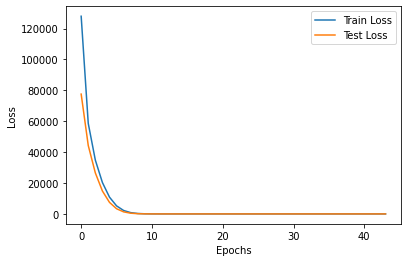

---------------------------------------------------------------------------------
Epoch : 44 / 500



Train Loss: 0.7016987170733459 | Train KL: 0.06804799077147287
Train Acc: [0.5019504  0.4973404  0.49539006 0.49539006 0.5053192  0.49162233
 0.52349293 0.51644504 0.5153369  0.49840426 0.5179078  0.51312053
 0.51710993 0.51121455 0.4864362 ]
Test Loss: 0.6997400257322524 | Test KL: 0.06806229054927826
Test Acc: [0.5251736  0.5303819  0.4809028  0.5251736  0.5425347  0.5338542
 0.48697916 0.5095486  0.5095486  0.49913195 0.5086806  0.5251736
 0.5546875  0.5451389  0.5234375 ]


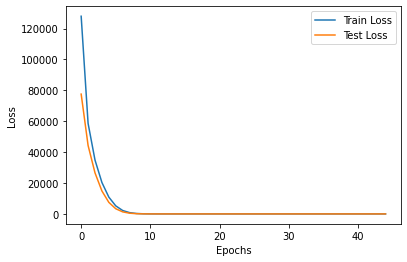

---------------------------------------------------------------------------------
Epoch : 45 / 500



Train Loss: 0.7013575396639236 | Train KL: 0.06801499648297087
Train Acc: [0.49955675 0.52477837 0.5092642  0.49840426 0.506383   0.5045656
 0.502305   0.51121455 0.5182181  0.5170213  0.510461   0.5118351
 0.51023936 0.5133422  0.49689716]
Test Loss: 0.7005210022131602 | Test KL: 0.06826723366975784
Test Acc: [0.5208333  0.4904514  0.5112847  0.5164931  0.48524305 0.5364583
 0.53125    0.49305555 0.5347222  0.5        0.5121528  0.5078125
 0.5173611  0.5321181  0.5277778 ]


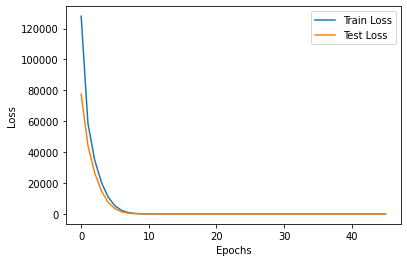

---------------------------------------------------------------------------------
Epoch : 46 / 500



Epoch    47: reducing learning rate of group 0 to 6.2500e-05.
Train Loss: 0.7011202074957232 | Train KL: 0.06809373427156015
Train Acc: [0.5140958  0.5075798  0.5134309  0.50585103 0.51245564 0.5018617
 0.50328016 0.5205231  0.5113918  0.51360816 0.51901597 0.5072695
 0.50483155 0.5129876  0.50026596]
Test Loss: 0.7004154688782163 | Test KL: 0.06815988570451736
Test Acc: [0.4904514  0.5234375  0.5277778  0.5269097  0.515625   0.5112847
 0.5277778  0.4887153  0.47569445 0.5277778  0.5529514  0.49479166
 0.5017361  0.5130208  0.4956597 ]


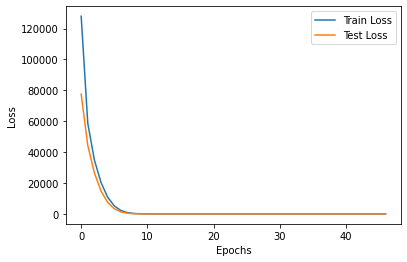

---------------------------------------------------------------------------------
Epoch : 47 / 500



Train Loss: 0.7010193276912609 | Train KL: 0.06802625573695974
Train Acc: [0.514672   0.51094854 0.50678194 0.49716312 0.51054966 0.5226507
 0.5092642  0.5152925  0.50097513 0.5136968  0.51586884 0.51134753
 0.5081117  0.50882095 0.51068264]
Test Loss: 0.7004866235786014 | Test KL: 0.06806005537509918
Test Acc: [0.5451389  0.4748264  0.4939236  0.4861111  0.5460069  0.5112847
 0.48697916 0.5199653  0.5017361  0.4965278  0.5633681  0.5
 0.546875   0.5260417  0.5086806 ]


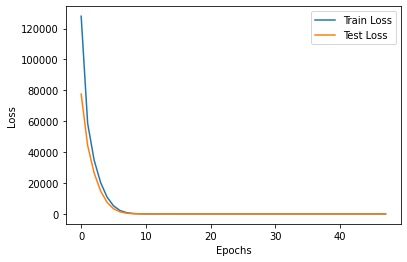

---------------------------------------------------------------------------------
Epoch : 48 / 500



Train Loss: 0.7008368584281164 | Train KL: 0.06809754505859199
Train Acc: [0.5256206  0.5134752  0.51223403 0.506383   0.51312053 0.5034575
 0.5179078  0.5028369  0.51600176 0.5256206  0.5005319  0.50438833
 0.510461   0.5079344  0.49773937]
Test Loss: 0.7008691297637092 | Test KL: 0.06806567311286926
Test Acc: [0.5043403  0.5286458  0.5060764  0.5338542  0.5251736  0.5416667
 0.4956597  0.49479166 0.5182292  0.4782986  0.5147569  0.5243056
 0.4626736  0.5095486  0.5199653 ]


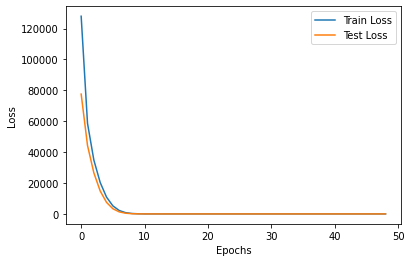

---------------------------------------------------------------------------------
Epoch : 49 / 500



Train Loss: 0.7008101601972647 | Train KL: 0.06796592067108087
Train Acc: [0.4962766  0.5133422  0.5297429  0.5056294  0.52876776 0.5221188
 0.5095745  0.5175532  0.5157358  0.51090425 0.51068264 0.512367
 0.508023   0.5014184  0.49960107]
Test Loss: 0.7013440082470576 | Test KL: 0.06800642609596252
Test Acc: [0.5164931 0.5251736 0.5277778 0.5130208 0.5182292 0.5416667 0.5329861
 0.5434028 0.5008681 0.5086806 0.5138889 0.5       0.4826389 0.5147569
 0.4878472]


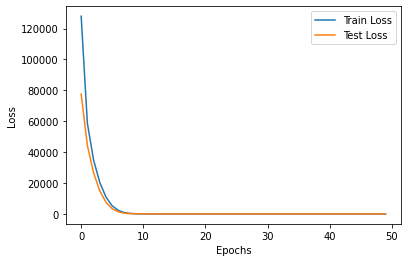

---------------------------------------------------------------------------------
Epoch : 50 / 500



Train Loss: 0.7008580713407367 | Train KL: 0.06802288828589392
Train Acc: [0.5029255  0.5140071  0.50460994 0.5095745  0.5178191  0.52664006
 0.5242021  0.514539   0.5242908  0.51099294 0.5163564  0.52961
 0.50647163 0.51094854 0.49818262]
Test Loss: 0.7023326539331012 | Test KL: 0.06774229556322098
Test Acc: [0.515625   0.5355903  0.4861111  0.5182292  0.4861111  0.5112847
 0.49305555 0.484375   0.4965278  0.5234375  0.5026042  0.4826389
 0.5190972  0.49739584 0.49305555]


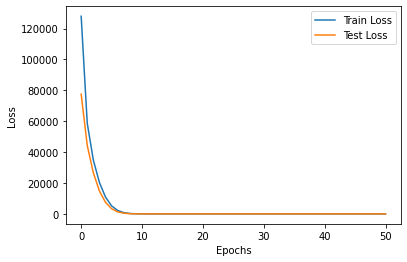

---------------------------------------------------------------------------------
Epoch : 51 / 500



Train Loss: 0.7015598120418847 | Train KL: 0.06800528906338604
Train Acc: [0.51037234 0.51799643 0.5099734  0.5078457  0.50518614 0.5070479
 0.50948584 0.5155585  0.5238475  0.5076241  0.50904256 0.50394505
 0.48829785 0.51799643 0.50372344]
Test Loss: 0.7013218022055097 | Test KL: 0.06799972057342529
Test Acc: [0.5112847  0.5104167  0.5121528  0.48350695 0.4921875  0.5529514
 0.5043403  0.5034722  0.4887153  0.5512153  0.5373264  0.48350695
 0.5572917  0.5260417  0.4956597 ]


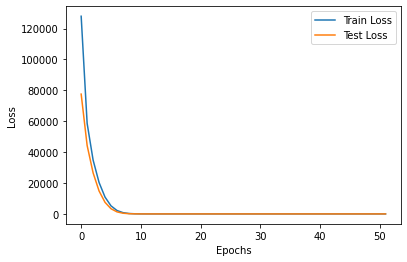

---------------------------------------------------------------------------------
Epoch : 52 / 500



Train Loss: 0.701200212147219 | Train KL: 0.06803853862674523
Train Acc: [0.5305851  0.5107713  0.5086879  0.5027926  0.52318263 0.5153369
 0.5120124  0.5163564  0.49942374 0.5010638  0.5087766  0.5130319
 0.5083777  0.51245564 0.5035904 ]
Test Loss: 0.700488731265068 | Test KL: 0.06799198687076569
Test Acc: [0.4965278  0.5251736  0.5199653  0.5008681  0.5347222  0.5095486
 0.47395834 0.48697916 0.5425347  0.5277778  0.5008681  0.5416667
 0.49913195 0.5277778  0.5347222 ]


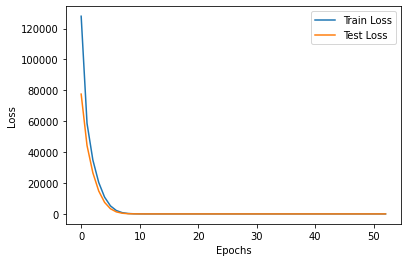

---------------------------------------------------------------------------------
Epoch : 53 / 500



Epoch    54: reducing learning rate of group 0 to 3.1250e-05.
Train Loss: 0.7005197198678416 | Train KL: 0.06798672438301939
Train Acc: [0.5023936  0.5289894  0.5128103  0.5140071  0.50961876 0.5240692
 0.52176416 0.51990247 0.5130319  0.52433515 0.50514185 0.50093085
 0.50948584 0.50700355 0.50460994]
Test Loss: 0.7009185916847653 | Test KL: 0.0679425522685051
Test Acc: [0.5069444  0.4904514  0.5199653  0.5026042  0.5234375  0.49305555
 0.5338542  0.5043403  0.5243056  0.546875   0.5251736  0.5277778
 0.4982639  0.4748264  0.4826389 ]


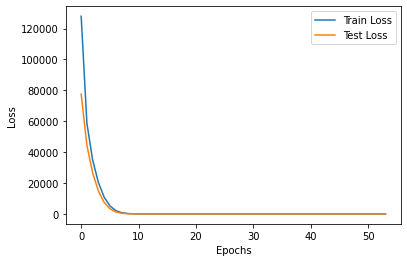

---------------------------------------------------------------------------------
Epoch : 54 / 500



Train Loss: 0.7010920648033737 | Train KL: 0.0680018681900721
Train Acc: [0.5177748  0.5097961  0.5191046  0.5065159  0.5134309  0.5136968
 0.5155585  0.5213652  0.51068264 0.51675534 0.51023936 0.5138741
 0.510594   0.50966316 0.48843086]
Test Loss: 0.7023517373535368 | Test KL: 0.06793123483657837
Test Acc: [0.4904514  0.4904514  0.5164931  0.5069444  0.48697916 0.4861111
 0.5295139  0.48958334 0.5095486  0.5164931  0.484375   0.4878472
 0.49913195 0.5208333  0.5138889 ]


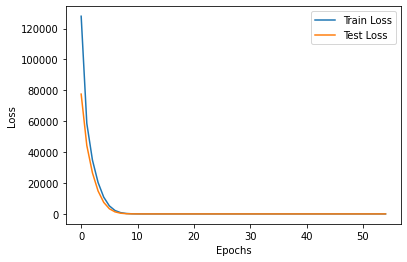

---------------------------------------------------------------------------------
Epoch : 55 / 500



Train Loss: 0.7010746585561874 | Train KL: 0.0679827742542781
Train Acc: [0.49397165 0.5150266  0.51037234 0.50527483 0.5075798  0.50549644
 0.5034575  0.51480496 0.5062943  0.51600176 0.52752656 0.52664006
 0.51028365 0.5065159  0.5086879 ]
Test Loss: 0.7014835857682757 | Test KL: 0.06810392439365387
Test Acc: [0.5008681  0.5329861  0.5034722  0.5034722  0.5164931  0.5208333
 0.5442708  0.5486111  0.5069444  0.48697916 0.5069444  0.48524305
 0.5199653  0.49739584 0.46354166]


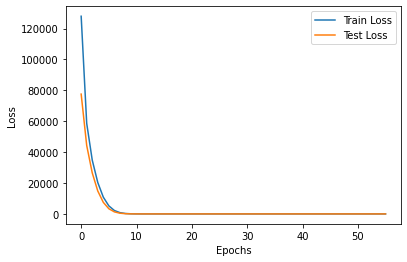

---------------------------------------------------------------------------------
Epoch : 56 / 500



Train Loss: 0.7009886655401676 | Train KL: 0.06797512736937679
Train Acc: [0.50070924 0.51414007 0.50806737 0.51870567 0.50766844 0.49809396
 0.5117021  0.5140071  0.5026153  0.518484   0.5001773  0.5071808
 0.51879436 0.5193262  0.5022606 ]
Test Loss: 0.7031901362869475 | Test KL: 0.06788815557956696
Test Acc: [0.4722222  0.48350695 0.53125    0.49305555 0.5069444  0.5034722
 0.5078125  0.5173611  0.4982639  0.49913195 0.5269097  0.5008681
 0.48958334 0.5199653  0.5147569 ]


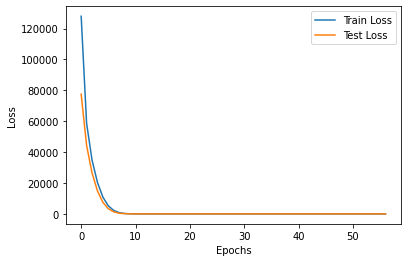

---------------------------------------------------------------------------------
Epoch : 57 / 500



Train Loss: 0.7009131840780272 | Train KL: 0.06801692834982635
Train Acc: [0.50992906 0.5112589  0.50416666 0.5008422  0.5176862  0.5066046
 0.51733154 0.50540775 0.5201684  0.5059397  0.5133422  0.5307181
 0.5227394  0.5121454  0.5065159 ]
Test Loss: 0.7006965892182456 | Test KL: 0.06799556314945221
Test Acc: [0.5017361  0.5225694  0.5260417  0.5095486  0.5147569  0.5390625
 0.4904514  0.5260417  0.49913195 0.49479166 0.5217014  0.5208333
 0.4982639  0.48958334 0.49131945]


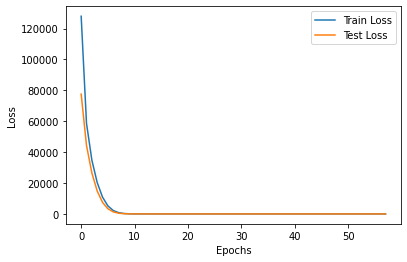

---------------------------------------------------------------------------------
Epoch : 58 / 500



Train Loss: 0.7009802401488554 | Train KL: 0.06797694737184132
Train Acc: [0.5046986  0.524867   0.5083777  0.5119238  0.51839536 0.51179075
 0.5287234  0.5212323  0.5092642  0.50948584 0.51458335 0.5010638
 0.51414007 0.51524824 0.4823138 ]
Test Loss: 0.7024783508645164 | Test KL: 0.06799870729446411
Test Acc: [0.4939236  0.5104167  0.49131945 0.46006945 0.515625   0.45833334
 0.5225694  0.5069444  0.515625   0.5008681  0.5086806  0.4982639
 0.46875    0.5026042  0.5277778 ]


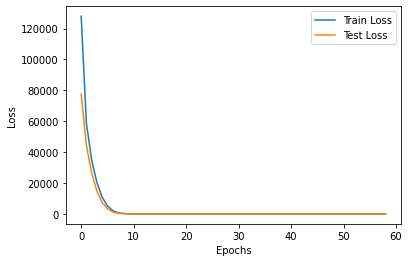

---------------------------------------------------------------------------------
Epoch : 59 / 500



Train Loss: 0.7009634134617257 | Train KL: 0.06800153587304109
Train Acc: [0.5086436  0.523227   0.49893615 0.50797874 0.5034131  0.5135638
 0.50735813 0.49982268 0.5138741  0.52371454 0.5134309  0.51644504
 0.50115246 0.5164893  0.50611705]
Test Loss: 0.7000659753878912 | Test KL: 0.06791019439697266
Test Acc: [0.5060764  0.49739584 0.4861111  0.5251736  0.4921875  0.5347222
 0.5164931  0.5355903  0.5086806  0.49913195 0.53125    0.5130208
 0.5321181  0.546875   0.4982639 ]


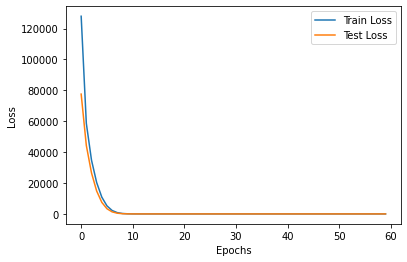

---------------------------------------------------------------------------------
Epoch : 60 / 500



Epoch    61: reducing learning rate of group 0 to 1.5625e-05.
Train Loss: 0.7005862331559473 | Train KL: 0.06799878993778365
Train Acc: [0.508555   0.5071808  0.5066046  0.4966312  0.49485818 0.5164893
 0.51742023 0.5172429  0.5050975  0.5108156  0.51094854 0.5246454
 0.51710993 0.51245564 0.49871454]
Test Loss: 0.7033849590354495 | Test KL: 0.0681496113538742
Test Acc: [0.5173611  0.5407986  0.5026042  0.4921875  0.5060764  0.4782986
 0.484375   0.49739584 0.5043403  0.4878472  0.5        0.5052083
 0.48697916 0.5182292  0.5078125 ]


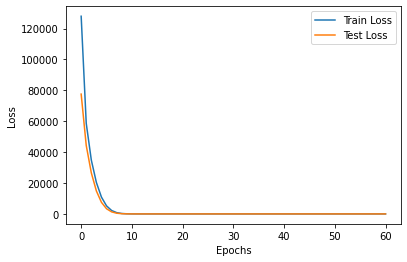

---------------------------------------------------------------------------------
Epoch : 61 / 500



Train Loss: 0.7011438058623185 | Train KL: 0.06802222418024186
Train Acc: [0.50039893 0.51586884 0.5081117  0.49264187 0.5235372  0.50567377
 0.51015073 0.51546985 0.50735813 0.51223403 0.51578015 0.50429964
 0.50536346 0.52606386 0.5144504 ]
Test Loss: 0.7013391885492537 | Test KL: 0.06789860874414444
Test Acc: [0.5034722  0.49305555 0.5373264  0.5260417  0.4861111  0.5138889
 0.5086806  0.5052083  0.5173611  0.5095486  0.5147569  0.5043403
 0.4904514  0.5173611  0.4652778 ]


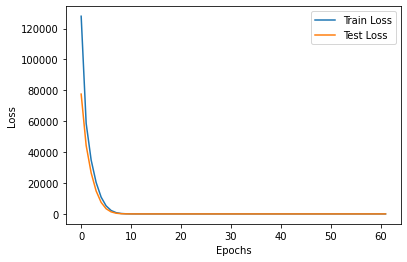

---------------------------------------------------------------------------------
Epoch : 62 / 500



Train Loss: 0.7014142160720014 | Train KL: 0.06801824229406127
Train Acc: [0.49539006 0.5182181  0.50048757 0.5136968  0.49871454 0.51094854
 0.51090425 0.50766844 0.5120124  0.51600176 0.5049202  0.5085993
 0.5156472  0.51524824 0.50296986]
Test Loss: 0.7000983539554808 | Test KL: 0.0680031031370163
Test Acc: [0.5234375  0.5147569  0.5434028  0.5017361  0.5008681  0.5390625
 0.5199653  0.48524305 0.5060764  0.5069444  0.5052083  0.5095486
 0.5052083  0.5138889  0.4939236 ]


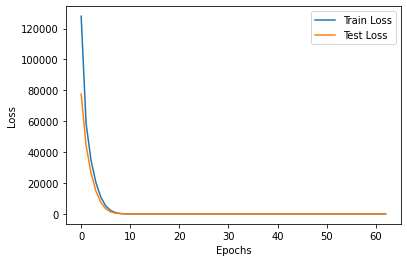

---------------------------------------------------------------------------------
Epoch : 63 / 500



Train Loss: 0.7013373560939274 | Train KL: 0.06798642593706754
Train Acc: [0.5072695  0.5280585  0.5167996  0.49095744 0.50545216 0.50580674
 0.52012414 0.50460994 0.5057181  0.50447696 0.5028812  0.5285461
 0.50496453 0.51480496 0.5057181 ]
Test Loss: 0.7009618331988653 | Test KL: 0.06801211088895798
Test Acc: [0.515625   0.4939236  0.5338542  0.5243056  0.5173611  0.46614584
 0.5373264  0.5138889  0.5355903  0.5017361  0.5138889  0.5043403
 0.4748264  0.4939236  0.5086806 ]


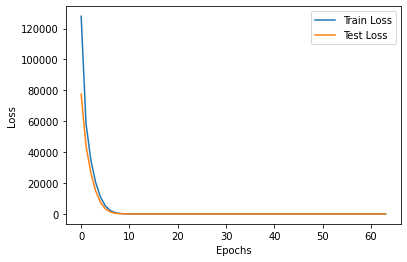

---------------------------------------------------------------------------------
Epoch : 64 / 500



Train Loss: 0.7013649188034924 | Train KL: 0.06797117819177344
Train Acc: [0.5131649  0.49020392 0.5095745  0.5035018  0.50948584 0.5086879
 0.5133422  0.5159131  0.5123227  0.52207446 0.5081117  0.49840426
 0.49760637 0.51990247 0.49530143]
Test Loss: 0.7014184064335294 | Test KL: 0.06801999360322952
Test Acc: [0.4704861 0.5225694 0.5095486 0.5       0.5234375 0.5130208 0.5529514
 0.4939236 0.5243056 0.5164931 0.5164931 0.5104167 0.5017361 0.5260417
 0.4748264]


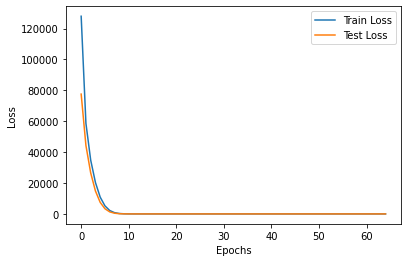

---------------------------------------------------------------------------------
Epoch : 65 / 500



Train Loss: 0.7008299354120349 | Train KL: 0.06802738114451685
Train Acc: [0.52109927 0.5077128  0.4985816  0.51068264 0.5127216  0.5040337
 0.51733154 0.5092642  0.52455676 0.529078   0.514672   0.5092199
 0.5155585  0.5082447  0.49308512]
Test Loss: 0.7000709474086761 | Test KL: 0.06794513761997223
Test Acc: [0.49739584 0.5        0.4782986  0.5329861  0.5173611  0.5078125
 0.5381944  0.5217014  0.5277778  0.4921875  0.5399306  0.5138889
 0.49479166 0.5503472  0.5190972 ]


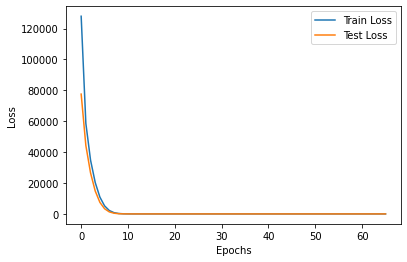

---------------------------------------------------------------------------------
Epoch : 66 / 500



Train Loss: 0.7013877190596668 | Train KL: 0.06793497434110506
Train Acc: [0.5078901  0.49951243 0.50992906 0.5132092  0.5162234  0.49454784
 0.5195479  0.5055851  0.49321806 0.5002216  0.5059397  0.5089096
 0.50691485 0.5134752  0.50514185]
Test Loss: 0.702541740404235 | Test KL: 0.06801354885101318
Test Acc: [0.4965278  0.5043403  0.4826389  0.5277778  0.5104167  0.4782986
 0.5078125  0.5329861  0.49913195 0.5355903  0.48524305 0.47916666
 0.4782986  0.5347222  0.4809028 ]


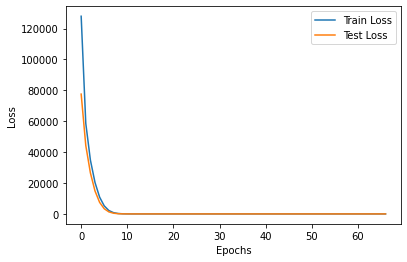

---------------------------------------------------------------------------------
Epoch : 67 / 500



Epoch    68: reducing learning rate of group 0 to 7.8125e-06.
Train Loss: 0.7015475575805555 | Train KL: 0.06799344057943804
Train Acc: [0.5072695  0.50647163 0.5060727  0.5030585  0.5076241  0.5035018
 0.5089096  0.5121454  0.5133422  0.50536346 0.49485818 0.50048757
 0.5189717  0.5149823  0.51524824]
Test Loss: 0.701704752114084 | Test KL: 0.06815734505653381
Test Acc: [0.5199653  0.5086806  0.5269097  0.4809028  0.5060764  0.5338542
 0.48524305 0.5052083  0.5173611  0.46961805 0.5347222  0.5494792
 0.4730903  0.4626736  0.4878472 ]


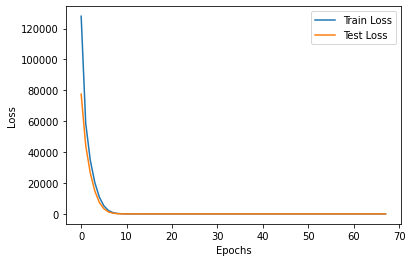

---------------------------------------------------------------------------------
Epoch : 68 / 500



Train Loss: 0.7020825807084429 | Train KL: 0.0680310586137129
Train Acc: [0.5095745  0.5093528  0.5049202  0.5056294  0.52455676 0.5019504
 0.50647163 0.49286348 0.5193262  0.4885638  0.5184397  0.508555
 0.4907358  0.5095745  0.49760637]
Test Loss: 0.7014079160160489 | Test KL: 0.06815046817064285
Test Acc: [0.5069444  0.5321181  0.4956597  0.5234375  0.5104167  0.4921875
 0.48177084 0.4861111  0.5434028  0.5329861  0.48697916 0.5034722
 0.5182292  0.5277778  0.47916666]


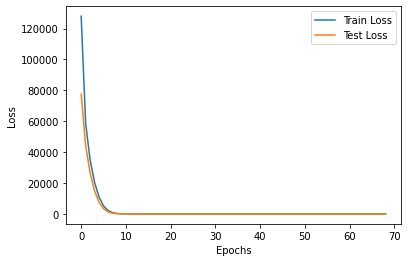

---------------------------------------------------------------------------------
Epoch : 69 / 500



Train Loss: 0.7013458782899464 | Train KL: 0.06801419837255004
Train Acc: [0.51511526 0.49530143 0.51090425 0.5046986  0.5128989  0.5121011
 0.51325357 0.50328016 0.50031024 0.51068264 0.51742023 0.51764184
 0.5008422  0.5212323  0.4988032 ]
Test Loss: 0.700654708676868 | Test KL: 0.06799040734767914
Test Acc: [0.47916666 0.5407986  0.5173611  0.5303819  0.5095486  0.4887153
 0.5260417  0.5277778  0.49305555 0.5217014  0.5329861  0.5277778
 0.4861111  0.5121528  0.4652778 ]


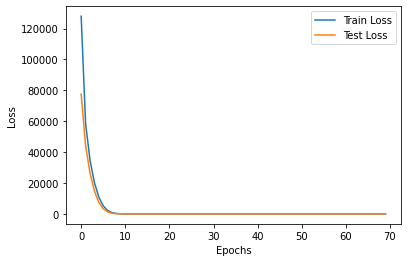

---------------------------------------------------------------------------------
Epoch : 70 / 500



Train Loss: 0.7009471151845675 | Train KL: 0.06790764233533372
Train Acc: [0.50624996 0.5167996  0.50917554 0.51054966 0.49804965 0.5180851
 0.5177748  0.5134752  0.49259755 0.5196366  0.4985816  0.50992906
 0.5237588  0.50536346 0.49060285]
Test Loss: 0.7013636098967658 | Test KL: 0.0680229440331459
Test Acc: [0.48958334 0.47916666 0.49305555 0.5138889  0.5069444  0.5138889
 0.5373264  0.5086806  0.5295139  0.5190972  0.4965278  0.5095486
 0.5338542  0.4878472  0.4730903 ]


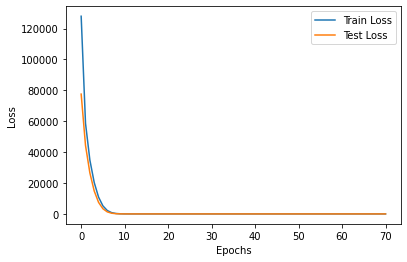

---------------------------------------------------------------------------------
Epoch : 71 / 500



Train Loss: 0.7014635932360981 | Train KL: 0.06802076835792961
Train Acc: [0.5107713  0.502172   0.49720743 0.5020833  0.5120124  0.5200798
 0.504211   0.5119238  0.5198582  0.51675534 0.5132092  0.49942374
 0.504078   0.5093528  0.5022606 ]
Test Loss: 0.699929760562049 | Test KL: 0.06795556843280792
Test Acc: [0.4982639  0.5538194  0.5512153  0.4809028  0.5321181  0.5173611
 0.5173611  0.5243056  0.5104167  0.48697916 0.5286458  0.49305555
 0.5477431  0.5243056  0.48524305]


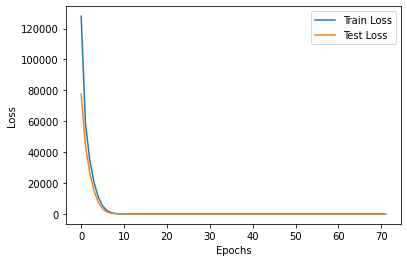

---------------------------------------------------------------------------------
Epoch : 72 / 500



Train Loss: 0.7018158693685599 | Train KL: 0.06798256479256543
Train Acc: [0.5078901  0.5172429  0.5120124  0.50394505 0.5094415  0.5256649
 0.5022606  0.5074468  0.49809396 0.523227   0.5180851  0.5085993
 0.50602835 0.508023   0.49206558]
Test Loss: 0.700661634405454 | Test KL: 0.06800126284360886
Test Acc: [0.5182292  0.5494792  0.48524305 0.5381944  0.5303819  0.5616319
 0.47916666 0.5243056  0.5095486  0.5112847  0.5321181  0.49305555
 0.5364583  0.48958334 0.5052083 ]


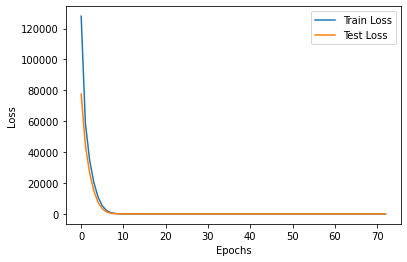

---------------------------------------------------------------------------------
Epoch : 73 / 500



Train Loss: 0.7013568041172433 | Train KL: 0.06799475336117101
Train Acc: [0.5239805  0.50536346 0.510461   0.5070479  0.5084663  0.51662236
 0.5013741  0.51103723 0.50035465 0.5035904  0.52092195 0.5251773
 0.5045656  0.5129876  0.4823138 ]
Test Loss: 0.700141093797154 | Test KL: 0.0680001750588417
Test Acc: [0.5451389 0.5182292 0.4921875 0.5034722 0.5       0.4878472 0.5130208
 0.5460069 0.5112847 0.53125   0.5381944 0.5026042 0.5121528 0.5251736
 0.4904514]


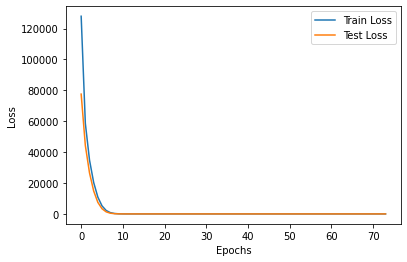

---------------------------------------------------------------------------------
Epoch : 74 / 500



Epoch    75: reducing learning rate of group 0 to 3.9063e-06.
Train Loss: 0.7010392918654368 | Train KL: 0.06795030229903282
Train Acc: [0.5196366  0.52021277 0.5126773  0.50518614 0.5089096  0.50970745
 0.5075798  0.5092642  0.5253103  0.5030585  0.5038121  0.5086879
 0.50939715 0.5169326  0.49454784]
Test Loss: 0.7016225374407239 | Test KL: 0.06784162670373917
Test Acc: [0.484375   0.5407986  0.5078125  0.5130208  0.5208333  0.5173611
 0.5052083  0.47743055 0.5121528  0.5243056  0.5        0.5017361
 0.46875    0.5043403  0.484375  ]


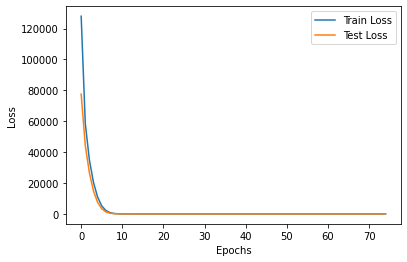

---------------------------------------------------------------------------------
Epoch : 75 / 500



Train Loss: 0.7009836160544808 | Train KL: 0.06796345516299525
Train Acc: [0.5135638  0.5121454  0.49242023 0.50079787 0.51906025 0.5028369
 0.51675534 0.50438833 0.50101954 0.5289894  0.5046986  0.50580674
 0.51103723 0.5242908  0.50328016]
Test Loss: 0.7010379119051827 | Test KL: 0.06788350641727448
Test Acc: [0.5086806  0.5138889  0.49479166 0.49479166 0.5147569  0.5138889
 0.5034722  0.5173611  0.5034722  0.5329861  0.5434028  0.5217014
 0.5303819  0.5069444  0.4861111 ]


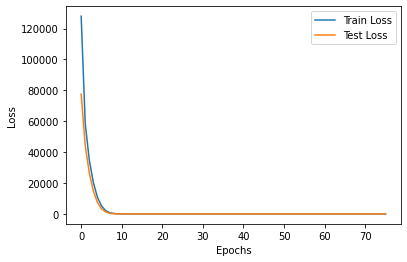

---------------------------------------------------------------------------------
Epoch : 76 / 500



Train Loss: 0.7015309477528782 | Train KL: 0.0679460717959607
Train Acc: [0.49685284 0.49729612 0.50110817 0.5010638  0.5011968  0.51675534
 0.5118351  0.50948584 0.5050089  0.52761525 0.5119238  0.5153369
 0.51493794 0.52282804 0.510461  ]
Test Loss: 0.7013625800609589 | Test KL: 0.0679883062839508
Test Acc: [0.5112847  0.5425347  0.5069444  0.5269097  0.5286458  0.5225694
 0.49739584 0.4861111  0.5286458  0.5208333  0.5078125  0.5138889
 0.49739584 0.5173611  0.4904514 ]


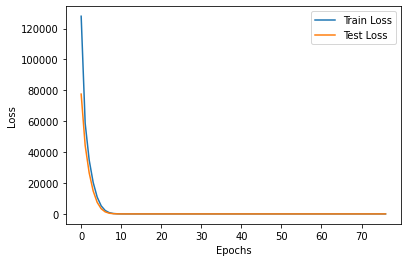

---------------------------------------------------------------------------------
Epoch : 77 / 500



Train Loss: 0.700673037809683 | Train KL: 0.06795674509613227
Train Acc: [0.5097961  0.5095745  0.5278369  0.50691485 0.5159131  0.5040337
 0.50664896 0.5056294  0.52433515 0.50882095 0.5289894  0.51263297
 0.5131649  0.52056736 0.50691485]
Test Loss: 0.7003155102332433 | Test KL: 0.06801783293485641
Test Acc: [0.5659722  0.5052083  0.5078125  0.5425347  0.47916666 0.5121528
 0.5208333  0.5373264  0.5173611  0.5199653  0.5399306  0.5164931
 0.5052083  0.5043403  0.5069444 ]


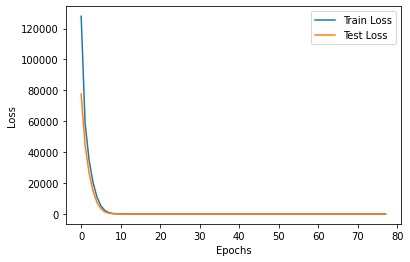

---------------------------------------------------------------------------------
Epoch : 78 / 500



Train Loss: 0.7017401858424464 | Train KL: 0.06805483542435559
Train Acc: [0.49960107 0.49250886 0.50806737 0.5127216  0.5171986  0.504211
 0.51245564 0.504344   0.51015073 0.51156914 0.51068264 0.51799643
 0.50115246 0.5129876  0.48617023]
Test Loss: 0.7011957698398166 | Test KL: 0.0679498240351677
Test Acc: [0.4965278  0.5286458  0.5069444  0.48177084 0.4826389  0.48177084
 0.48350695 0.5008681  0.5347222  0.5060764  0.515625   0.5008681
 0.5        0.5520833  0.4861111 ]


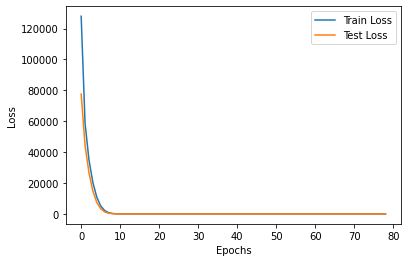

---------------------------------------------------------------------------------
Epoch : 79 / 500



Train Loss: 0.700802245038621 | Train KL: 0.06789556674078001
Train Acc: [0.50328016 0.50438833 0.52220744 0.52664006 0.5204344  0.5085106
 0.5135638  0.5100177  0.5176862  0.49649823 0.5039007  0.5114805
 0.50332445 0.5214982  0.49982268]
Test Loss: 0.7002099669641919 | Test KL: 0.0679468959569931
Test Acc: [0.5295139 0.5182292 0.5017361 0.5069444 0.5182292 0.5026042 0.5286458
 0.5173611 0.4887153 0.5286458 0.5190972 0.5243056 0.5364583 0.5260417
 0.4921875]


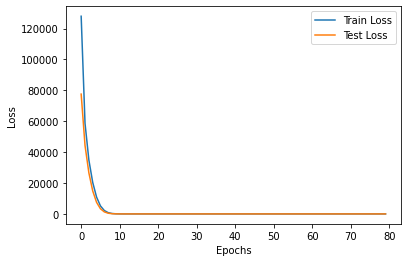

---------------------------------------------------------------------------------
Epoch : 80 / 500



Train Loss: 0.7010574556411581 | Train KL: 0.06798995497590261
Train Acc: [0.49321806 0.50483155 0.5078014  0.5059397  0.506383   0.52176416
 0.5084663  0.5078457  0.52087766 0.51945925 0.51294327 0.51875
 0.5281029  0.5160461  0.5028369 ]
Test Loss: 0.7007563263177872 | Test KL: 0.0680188313126564
Test Acc: [0.5425347  0.5243056  0.5086806  0.45399305 0.5017361  0.53125
 0.49739584 0.5199653  0.5607639  0.5338542  0.5104167  0.5173611
 0.5199653  0.5199653  0.5364583 ]


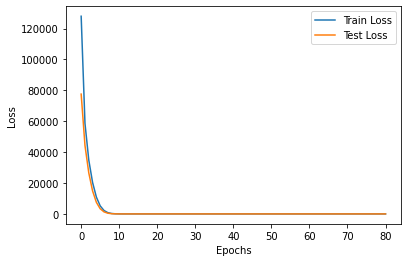

---------------------------------------------------------------------------------
Epoch : 81 / 500



Epoch    82: reducing learning rate of group 0 to 1.9531e-06.
Train Loss: 0.7012758348005038 | Train KL: 0.06797449375298006
Train Acc: [0.48408687 0.5119238  0.5062943  0.50966316 0.5140071  0.5133865
 0.5107269  0.50159574 0.5082447  0.50691485 0.5093528  0.5140958
 0.52251774 0.5001773  0.50766844]
Test Loss: 0.701575862036811 | Test KL: 0.06801266968250275
Test Acc: [0.5217014  0.5295139  0.5208333  0.5034722  0.5251736  0.49479166
 0.4982639  0.48697916 0.4939236  0.5190972  0.4982639  0.5043403
 0.5069444  0.4809028  0.5060764 ]


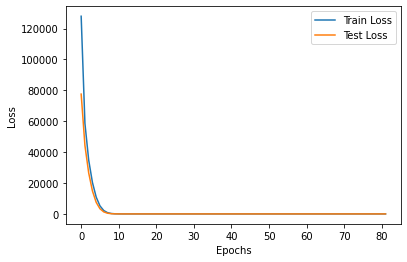

---------------------------------------------------------------------------------
Epoch : 82 / 500



Train Loss: 0.7013198065419569 | Train KL: 0.06798215939643536
Train Acc: [0.50735813 0.52025706 0.51054966 0.50647163 0.52389187 0.5239805
 0.52358156 0.5093528  0.5156915  0.5075798  0.51436174 0.5142287
 0.5035904  0.5128989  0.48887414]
Test Loss: 0.7015622009833654 | Test KL: 0.06797590851783752
Test Acc: [0.48958334 0.5060764  0.4730903  0.5121528  0.46354166 0.4956597
 0.5364583  0.5095486  0.49305555 0.5086806  0.5217014  0.5138889
 0.5390625  0.5269097  0.49479166]


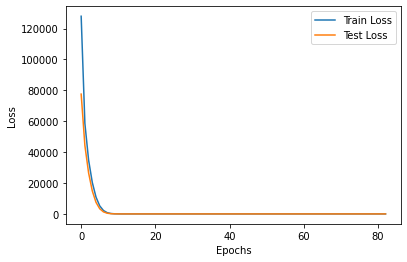

---------------------------------------------------------------------------------
Epoch : 83 / 500



Train Loss: 0.7010955916228869 | Train KL: 0.06802703503598558
Train Acc: [0.52154255 0.51733154 0.50124115 0.50070924 0.5056294  0.5117021
 0.51223403 0.52455676 0.52522165 0.5070922  0.49552307 0.51764184
 0.5062943  0.5183511  0.50385636]
Test Loss: 0.7008678002489938 | Test KL: 0.06802153587341309
Test Acc: [0.5260417  0.5112847  0.5190972  0.5112847  0.5407986  0.5225694
 0.5347222  0.5364583  0.5173611  0.4965278  0.5052083  0.5017361
 0.4878472  0.4809028  0.47569445]


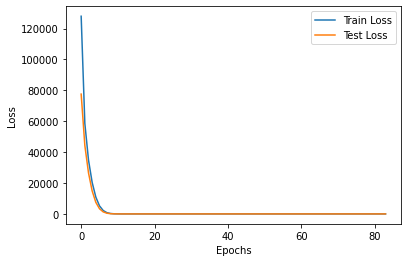

---------------------------------------------------------------------------------
Epoch : 84 / 500



Train Loss: 0.7007882611971374 | Train KL: 0.06800105163814328
Train Acc: [0.5071365  0.5031915  0.5185727  0.52539897 0.5244237  0.5027482
 0.50048757 0.5070479  0.516578   0.51054966 0.5233156  0.52034575
 0.52859044 0.50549644 0.5050532 ]
Test Loss: 0.6999172187513776 | Test KL: 0.06794726848602295
Test Acc: [0.5173611  0.5451389  0.5208333  0.5251736  0.5390625  0.4956597
 0.48958334 0.5043403  0.5130208  0.5208333  0.48524305 0.515625
 0.5572917  0.5147569  0.5347222 ]


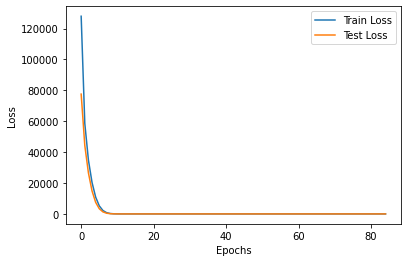

---------------------------------------------------------------------------------
Epoch : 85 / 500



Train Loss: 0.7012298627102629 | Train KL: 0.06796815447139402
Train Acc: [0.50478727 0.5126773  0.499867   0.49242023 0.51037234 0.523227
 0.5092642  0.5126773  0.5186613  0.51032805 0.5108156  0.52455676
 0.50097513 0.50948584 0.49388295]
Test Loss: 0.7016707559426626 | Test KL: 0.06797794997692108
Test Acc: [0.48177084 0.5130208  0.4878472  0.5329861  0.5208333  0.4965278
 0.4878472  0.49131945 0.4956597  0.53125    0.5225694  0.4861111
 0.49739584 0.5425347  0.48697916]


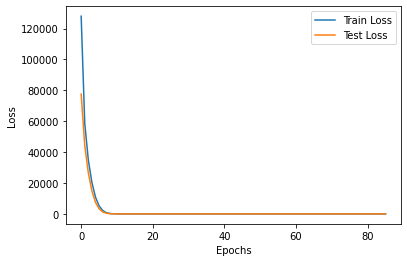

---------------------------------------------------------------------------------
Epoch : 86 / 500



Train Loss: 0.7013623790538057 | Train KL: 0.06798554127309339
Train Acc: [0.5026153  0.51382977 0.5093528  0.49773937 0.5050089  0.5059397
 0.50895387 0.49543437 0.5152925  0.5128103  0.5094415  0.51165783
 0.49995568 0.5075798  0.50478727]
Test Loss: 0.7020661847458946 | Test KL: 0.06801018118858337
Test Acc: [0.5173611  0.4904514  0.5034722  0.4748264  0.5407986  0.5329861
 0.5399306  0.4670139  0.5217014  0.4809028  0.5243056  0.4748264
 0.5138889  0.5164931  0.46788195]


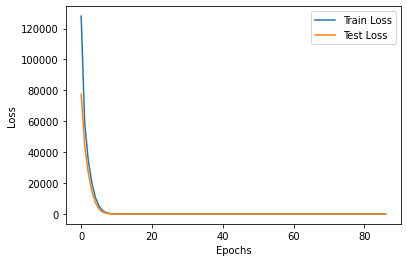

---------------------------------------------------------------------------------
Epoch : 87 / 500



Train Loss: 0.7015811885502321 | Train KL: 0.06798019276020374
Train Acc: [0.50039893 0.50647163 0.51187944 0.5071808  0.5072695  0.48882982
 0.499867   0.5193262  0.51458335 0.50904256 0.516578   0.5107713
 0.50447696 0.51812947 0.48222518]
Test Loss: 0.7007162570953369 | Test KL: 0.06798133999109268
Test Acc: [0.5225694  0.5190972  0.5164931  0.5347222  0.4861111  0.48524305
 0.5303819  0.5164931  0.5147569  0.5381944  0.5303819  0.5225694
 0.5260417  0.5347222  0.5095486 ]


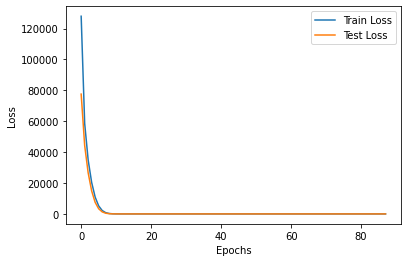

---------------------------------------------------------------------------------
Epoch : 88 / 500



Epoch    89: reducing learning rate of group 0 to 9.7656e-07.
Train Loss: 0.7013439675594898 | Train KL: 0.06800928764732171
Train Acc: [0.50115246 0.50602835 0.5213652  0.5001773  0.5082447  0.51414007
 0.5016844  0.5057181  0.5150266  0.5213652  0.5212766  0.5171986
 0.497828   0.49255317 0.5012855 ]
Test Loss: 0.7016870809925927 | Test KL: 0.0680256336927414
Test Acc: [0.5060764  0.5026042  0.5381944  0.5086806  0.5026042  0.5104167
 0.4904514  0.4809028  0.5190972  0.5086806  0.5095486  0.4809028
 0.5        0.5390625  0.49131945]


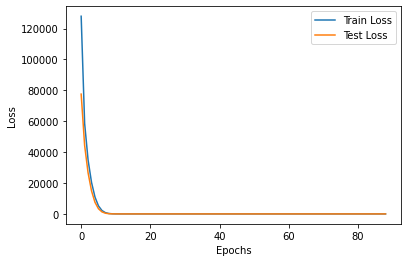

---------------------------------------------------------------------------------
Epoch : 89 / 500



Train Loss: 0.7015235550860142 | Train KL: 0.06800166427666414
Train Acc: [0.5140071  0.50917554 0.50527483 0.4969858  0.4966312  0.5020833
 0.5256206  0.5028369  0.51742023 0.51733154 0.52641845 0.5035018
 0.49100175 0.5121454  0.49720743]
Test Loss: 0.7029269486665726 | Test KL: 0.06796597689390182
Test Acc: [0.48177084 0.5260417  0.4904514  0.5190972  0.5234375  0.5251736
 0.4982639  0.4887153  0.5303819  0.4730903  0.5217014  0.48697916
 0.5        0.5286458  0.4800347 ]


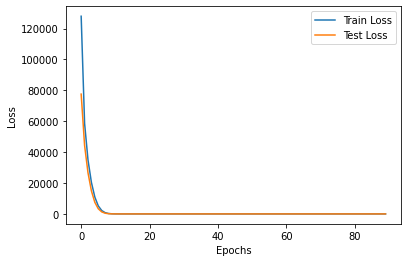

---------------------------------------------------------------------------------
Epoch : 90 / 500



Train Loss: 0.7009642610313199 | Train KL: 0.0679712325123185
Train Acc: [0.5019504  0.51294327 0.5142287  0.4949468  0.5134752  0.5147607
 0.5205231  0.5143174  0.5121454  0.5087766  0.5074025  0.5125887
 0.51990247 0.520789   0.49255317]
Test Loss: 0.7010944717460208 | Test KL: 0.06796759366989136
Test Acc: [0.5217014  0.484375   0.5243056  0.5112847  0.5182292  0.5
 0.5052083  0.48697916 0.5104167  0.5217014  0.5078125  0.5104167
 0.5043403  0.4965278  0.5       ]


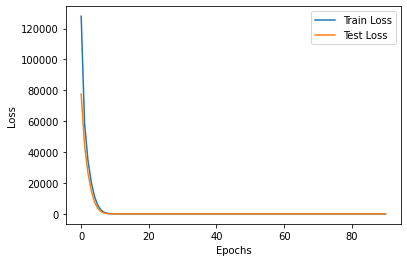

---------------------------------------------------------------------------------
Epoch : 91 / 500



Train Loss: 0.7009799729847739 | Train KL: 0.06799341162257161
Train Acc: [0.50939715 0.5050089  0.5132092  0.5013741  0.4971188  0.5288564
 0.50961876 0.5197695  0.4950798  0.51697695 0.51103723 0.5204344
 0.5130319  0.5136968  0.497961  ]
Test Loss: 0.7011347893211577 | Test KL: 0.06794995069503784
Test Acc: [0.5225694  0.5104167  0.5112847  0.49305555 0.5078125  0.47569445
 0.5260417  0.5086806  0.5303819  0.5121528  0.46006945 0.5303819
 0.53125    0.5277778  0.5208333 ]


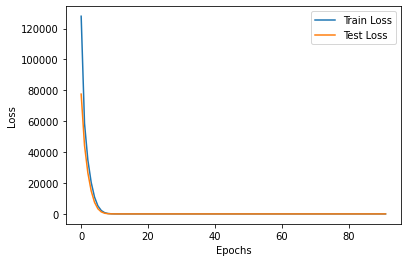

---------------------------------------------------------------------------------
Epoch : 92 / 500



Train Loss: 0.701237383886432 | Train KL: 0.06795585277021354
Train Acc: [0.5167996  0.51103723 0.5049202  0.5055851  0.5155585  0.5148936
 0.5143174  0.5125887  0.5193262  0.50474286 0.5008422  0.5072695
 0.5029255  0.5159131  0.50447696]
Test Loss: 0.7023583004872004 | Test KL: 0.06798103451728821
Test Acc: [0.48958334 0.48697916 0.4878472  0.5121528  0.5303819  0.4722222
 0.515625   0.5347222  0.4956597  0.5052083  0.4939236  0.5008681
 0.4965278  0.5460069  0.47135416]


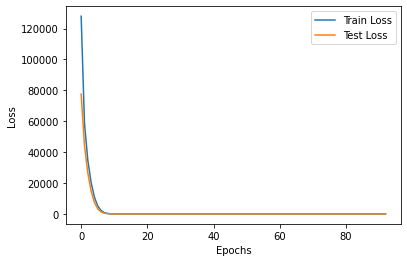

---------------------------------------------------------------------------------
Epoch : 93 / 500



Train Loss: 0.7007934552557925 | Train KL: 0.0679926372377585
Train Acc: [0.5117021  0.5045656  0.50328016 0.495656   0.5071365  0.5196366
 0.52101064 0.49751773 0.5177748  0.5204344  0.53226954 0.52752656
 0.50992906 0.5169326  0.5079344 ]
Test Loss: 0.7031353265047073 | Test KL: 0.06799841672182083
Test Acc: [0.49739584 0.5        0.5034722  0.4861111  0.5008681  0.5529514
 0.48524305 0.5625     0.5190972  0.4921875  0.4904514  0.5060764
 0.5260417  0.4782986  0.515625  ]


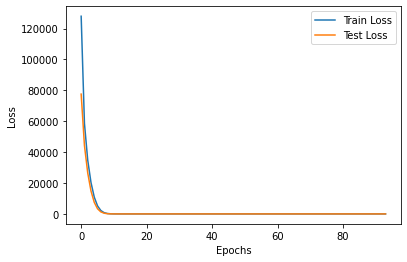

---------------------------------------------------------------------------------
Epoch : 94 / 500



Train Loss: 0.700806717923347 | Train KL: 0.06796899490745355
Train Acc: [0.5133422  0.510594   0.4991578  0.504078   0.51023936 0.51427305
 0.512367   0.50895387 0.5025709  0.51121455 0.50815606 0.51968086
 0.502172   0.49521273 0.50939715]
Test Loss: 0.7019941045178307 | Test KL: 0.06795630604028702
Test Acc: [0.4921875 0.5286458 0.5199653 0.5173611 0.5069444 0.4982639 0.4730903
 0.5069444 0.5069444 0.5138889 0.5260417 0.5017361 0.5060764 0.5217014
 0.4809028]


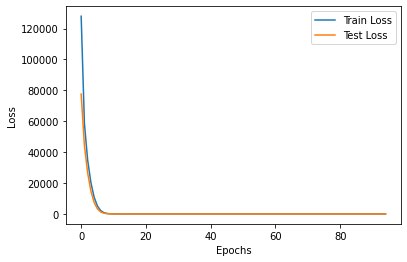

---------------------------------------------------------------------------------
Epoch : 95 / 500



Epoch    96: reducing learning rate of group 0 to 4.8828e-07.
Train Loss: 0.7016303543503403 | Train KL: 0.06799648020495759
Train Acc: [0.4986259  0.5118351  0.5036791  0.49609926 0.49968973 0.5185727
 0.51360816 0.50416666 0.5070479  0.5071365  0.5170213  0.52477837
 0.5156472  0.52176416 0.47491136]
Test Loss: 0.700994739929835 | Test KL: 0.0679950937628746
Test Acc: [0.48350695 0.5486111  0.47916666 0.4904514  0.53125    0.5373264
 0.5164931  0.5234375  0.5008681  0.5086806  0.5086806  0.5373264
 0.5286458  0.49739584 0.5026042 ]


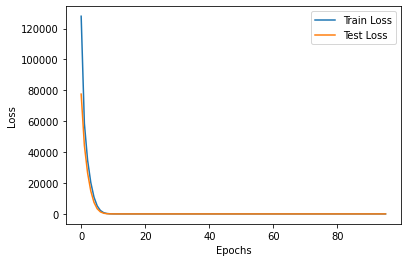

---------------------------------------------------------------------------------
Epoch : 96 / 500



Train Loss: 0.7017721918457789 | Train KL: 0.06800207236768506
Train Acc: [0.5086436  0.5219858  0.50514185 0.48829785 0.5126773  0.49898046
 0.5050532  0.4963209  0.51742023 0.50602835 0.5155585  0.5193262
 0.5055408  0.51121455 0.48687944]
Test Loss: 0.699378490447998 | Test KL: 0.06800943613052368
Test Acc: [0.5112847  0.5095486  0.5338542  0.5373264  0.5303819  0.5034722
 0.5225694  0.5164931  0.5538194  0.5190972  0.5303819  0.515625
 0.49479166 0.5130208  0.5208333 ]


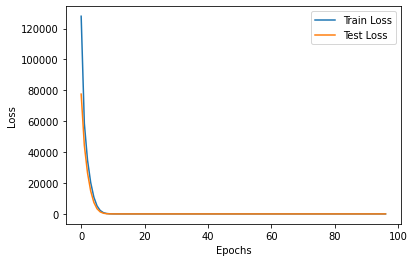

---------------------------------------------------------------------------------
Epoch : 97 / 500



Train Loss: 0.7011635337315553 | Train KL: 0.0679955560687586
Train Acc: [0.50806737 0.51156914 0.4988475  0.51054966 0.50549644 0.5072695
 0.5027039  0.5197252  0.51609045 0.51524824 0.5015071  0.52229613
 0.5228723  0.5204344  0.49556738]
Test Loss: 0.7021946973270841 | Test KL: 0.0680025964975357
Test Acc: [0.49739584 0.4921875  0.53125    0.5104167  0.5026042  0.5329861
 0.5060764  0.5        0.5251736  0.48524305 0.48177084 0.48524305
 0.5381944  0.5112847  0.4982639 ]


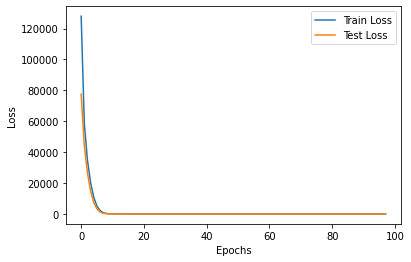

---------------------------------------------------------------------------------
Epoch : 98 / 500



Train Loss: 0.7011404417930766 | Train KL: 0.06800160541179333
Train Acc: [0.5028369  0.5133865  0.5171986  0.51023936 0.5017287  0.50026596
 0.5238475  0.51795214 0.5065159  0.5178191  0.50580674 0.51015073
 0.5077128  0.49818262 0.5079344 ]
Test Loss: 0.7018464008967081 | Test KL: 0.06799769401550293
Test Acc: [0.4782986  0.5078125  0.4956597  0.5138889  0.5078125  0.47916666
 0.5269097  0.5147569  0.5164931  0.4887153  0.5095486  0.4861111
 0.5225694  0.4965278  0.5442708 ]


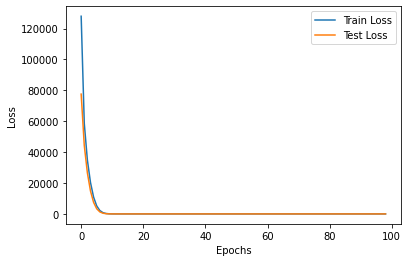

---------------------------------------------------------------------------------
Epoch : 99 / 500



Train Loss: 0.7014390348542666 | Train KL: 0.06799288580180905
Train Acc: [0.50518614 0.5167996  0.4969858  0.50518614 0.5150266  0.502305
 0.5159131  0.51414007 0.49973404 0.5171986  0.502172   0.51733154
 0.504211   0.5100177  0.4914007 ]
Test Loss: 0.7010808057255216 | Test KL: 0.06799808144569397
Test Acc: [0.46180555 0.4939236  0.5043403  0.5182292  0.48350695 0.5451389
 0.5130208  0.5260417  0.5434028  0.49131945 0.5277778  0.5208333
 0.5060764  0.515625   0.48697916]


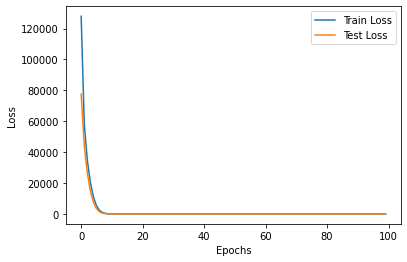

---------------------------------------------------------------------------------
Epoch : 100 / 500



Train Loss: 0.701089008480099 | Train KL: 0.0680109313193788
Train Acc: [0.5006206  0.5205231  0.5005319  0.514539   0.5185727  0.50035465
 0.50164    0.50580674 0.5035904  0.5066046  0.5205231  0.5138741
 0.5219858  0.50598407 0.5066046 ]
Test Loss: 0.7010235422187381 | Test KL: 0.06800790876150131
Test Acc: [0.5078125  0.5295139  0.49913195 0.5147569  0.48177084 0.5078125
 0.4904514  0.5329861  0.5173611  0.47395834 0.5347222  0.5086806
 0.5512153  0.5364583  0.4626736 ]


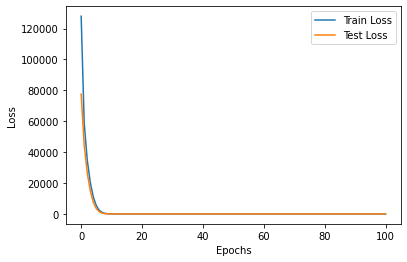

---------------------------------------------------------------------------------
Epoch : 101 / 500



Train Loss: 0.7014992858501191 | Train KL: 0.06800270630112777
Train Acc: [0.50580674 0.5056294  0.5079344  0.5055851  0.50483155 0.5027926
 0.51068264 0.518883   0.50691485 0.51906025 0.5134752  0.5138741
 0.5045656  0.5075798  0.50580674]
Test Loss: 0.7022019442584779 | Test KL: 0.06799569725990295
Test Acc: [0.5295139  0.5225694  0.49479166 0.49739584 0.5269097  0.5295139
 0.47743055 0.5095486  0.4765625  0.5182292  0.5208333  0.5008681
 0.4887153  0.5321181  0.4574653 ]


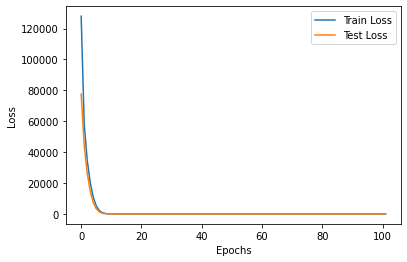

---------------------------------------------------------------------------------
Epoch : 102 / 500



Epoch   103: reducing learning rate of group 0 to 2.4414e-07.
Train Loss: 0.7008353391437666 | Train KL: 0.06800677891530044
Train Acc: [0.49530143 0.52163124 0.5133422  0.5028369  0.50190604 0.52012414
 0.516578   0.5200798  0.49995568 0.52358156 0.5242021  0.50536346
 0.50460994 0.5135638  0.5012855 ]
Test Loss: 0.7009933839241663 | Test KL: 0.06801065802574158
Test Acc: [0.5338542  0.48958334 0.5338542  0.5269097  0.46788195 0.4965278
 0.5217014  0.48524305 0.5086806  0.484375   0.5095486  0.5008681
 0.5164931  0.4965278  0.5199653 ]


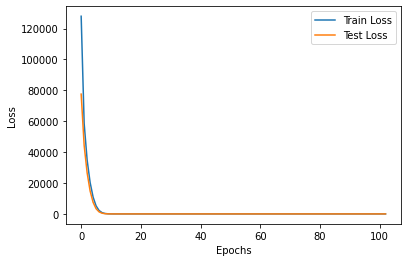

---------------------------------------------------------------------------------
Epoch : 103 / 500



Train Loss: 0.7014584114365544 | Train KL: 0.0680140271677193
Train Acc: [0.5098848  0.49982268 0.50882095 0.4886968  0.512766   0.49804965
 0.51285464 0.5019504  0.5214539  0.51728725 0.5199911  0.516844
 0.5027926  0.5175532  0.5095745 ]
Test Loss: 0.7016146845287747 | Test KL: 0.06801008433103561
Test Acc: [0.4956597  0.49305555 0.49479166 0.49131945 0.4861111  0.5086806
 0.5173611  0.5460069  0.5442708  0.5060764  0.5286458  0.5147569
 0.5017361  0.5416667  0.4826389 ]


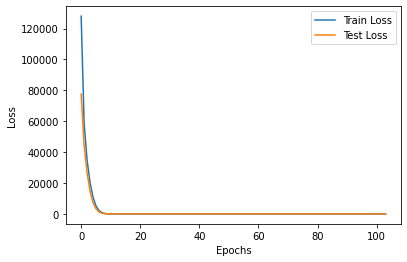

---------------------------------------------------------------------------------
Epoch : 104 / 500



Train Loss: 0.7010803607338709 | Train KL: 0.06800662562356773
Train Acc: [0.50115246 0.50815606 0.5035018  0.50545216 0.5276596  0.50895387
 0.51830673 0.5108156  0.50669324 0.522961   0.5134752  0.49893615
 0.51578015 0.50669324 0.50026596]
Test Loss: 0.7038529002004199 | Test KL: 0.06800702214241028
Test Acc: [0.4644097  0.48177084 0.5        0.4704861  0.48958334 0.5138889
 0.4956597  0.5329861  0.5251736  0.4765625  0.5243056  0.47569445
 0.4765625  0.484375   0.4982639 ]


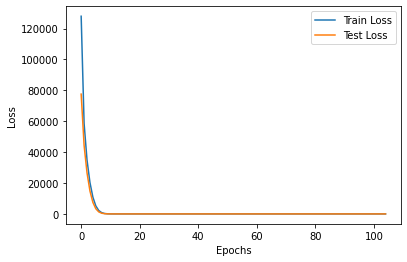

---------------------------------------------------------------------------------
Epoch : 105 / 500



Train Loss: 0.7009444587619592 | Train KL: 0.06800189661852857
Train Acc: [0.5025266  0.5184397  0.5089096  0.504344   0.5108156  0.5027482
 0.52025706 0.50961876 0.5173759  0.5128989  0.5177748  0.5114805
 0.5120124  0.51436174 0.49773937]
Test Loss: 0.7014856454398897 | Test KL: 0.06799859553575516
Test Acc: [0.5529514 0.4765625 0.515625  0.4878472 0.4965278 0.5       0.5364583
 0.5078125 0.5026042 0.4956597 0.484375  0.5008681 0.5260417 0.5373264
 0.5008681]


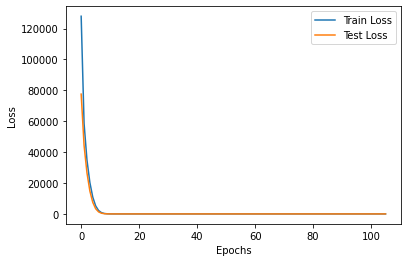

---------------------------------------------------------------------------------
Epoch : 106 / 500



Train Loss: 0.701294961973285 | Train KL: 0.067996158403285
Train Acc: [0.49596632 0.5117021  0.4949468  0.5036791  0.5034131  0.49747342
 0.52220744 0.5170213  0.5108156  0.51901597 0.5147607  0.5120567
 0.508289   0.5072695  0.49889183]
Test Loss: 0.7012205123901367 | Test KL: 0.06799840182065964
Test Acc: [0.5173611  0.5034722  0.5295139  0.484375   0.5026042  0.5052083
 0.5060764  0.5225694  0.5130208  0.48958334 0.47743055 0.47916666
 0.5338542  0.5494792  0.5086806 ]


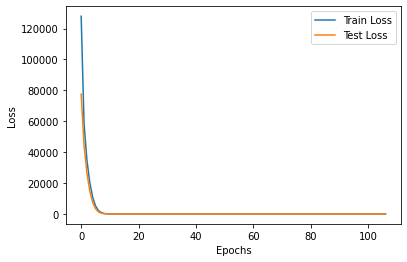

---------------------------------------------------------------------------------
Epoch : 107 / 500



Train Loss: 0.7014994866459082 | Train KL: 0.06800229873851682
Train Acc: [0.510594   0.51325357 0.50460994 0.49308512 0.49804965 0.51471627
 0.49982268 0.51546985 0.5028812  0.49609926 0.51688826 0.51742023
 0.5091312  0.51524824 0.49552307]
Test Loss: 0.7002890970971849 | Test KL: 0.06800369173288345
Test Acc: [0.5199653 0.515625  0.5138889 0.5190972 0.5243056 0.5355903 0.5078125
 0.5104167 0.5069444 0.5138889 0.5329861 0.5190972 0.4826389 0.5381944
 0.4904514]


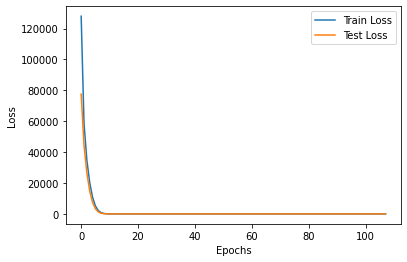

---------------------------------------------------------------------------------
Epoch : 108 / 500



Train Loss: 0.7007092296654451 | Train KL: 0.06800547326710207
Train Acc: [0.5156915  0.51187944 0.5121454  0.5078901  0.5097961  0.50483155
 0.5121454  0.5128103  0.5006206  0.51179075 0.51764184 0.520656
 0.52030146 0.5180851  0.50478727]
Test Loss: 0.7010375062624613 | Test KL: 0.06800137460231781
Test Acc: [0.49479166 0.5390625  0.5069444  0.4730903  0.5373264  0.46961805
 0.5069444  0.5104167  0.5373264  0.5121528  0.5208333  0.4904514
 0.5425347  0.5095486  0.5303819 ]


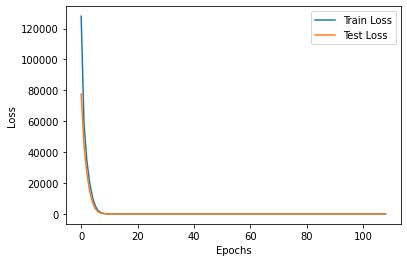

---------------------------------------------------------------------------------
Epoch : 109 / 500



Epoch   110: reducing learning rate of group 0 to 1.2207e-07.
Train Loss: 0.7012842754100231 | Train KL: 0.06799621732099682
Train Acc: [0.5177748  0.50474286 0.50265956 0.50527483 0.50917554 0.51901597
 0.51471627 0.51103723 0.50616133 0.5072695  0.51613474 0.50048757
 0.5183511  0.5093528  0.5071808 ]
Test Loss: 0.7016441739267774 | Test KL: 0.06799003481864929
Test Acc: [0.4887153  0.5225694  0.5078125  0.515625   0.5086806  0.5303819
 0.5260417  0.5390625  0.5121528  0.5017361  0.5355903  0.46875
 0.5112847  0.48958334 0.5060764 ]


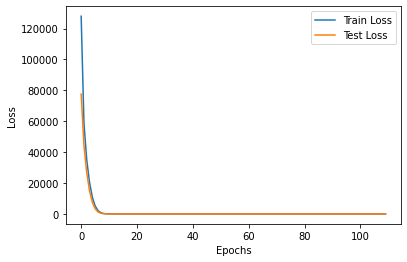

---------------------------------------------------------------------------------
Epoch : 110 / 500



Train Loss: 0.7009970545768738 | Train KL: 0.06798944527164419
Train Acc: [0.50394505 0.51538116 0.50536346 0.5185727  0.5013741  0.514539
 0.51360816 0.51728725 0.5246454  0.5027482  0.5068263  0.506383
 0.49973404 0.51121455 0.51733154]
Test Loss: 0.7023692942327924 | Test KL: 0.06798660010099411
Test Acc: [0.5138889  0.5451389  0.5208333  0.5        0.4644097  0.47916666
 0.5147569  0.5034722  0.4921875  0.4965278  0.4809028  0.5008681
 0.4748264  0.5364583  0.4609375 ]


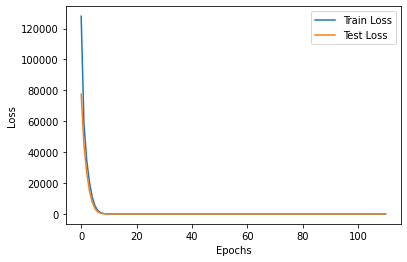

---------------------------------------------------------------------------------
Epoch : 111 / 500



Train Loss: 0.7017234580736633 | Train KL: 0.06798661986352704
Train Acc: [0.5012855  0.50483155 0.49516842 0.5040337  0.5149823  0.495656
 0.4988475  0.5117021  0.5068263  0.5029255  0.5112589  0.5183511
 0.5006206  0.50961876 0.5036791 ]
Test Loss: 0.7021287100182639 | Test KL: 0.06798809766769409
Test Acc: [0.47569445 0.5217014  0.5043403  0.49739584 0.5217014  0.4800347
 0.5347222  0.4861111  0.5173611  0.47743055 0.5434028  0.5095486
 0.5164931  0.5234375  0.4730903 ]


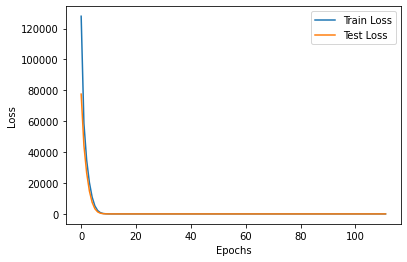

---------------------------------------------------------------------------------
Epoch : 112 / 500



Train Loss: 0.7012084916973791 | Train KL: 0.0679882899032417
Train Acc: [0.5176862  0.51609045 0.51023936 0.51263297 0.50181735 0.50815606
 0.52092195 0.51710993 0.51037234 0.52087766 0.51728725 0.5092199
 0.5095745  0.51156914 0.49951243]
Test Loss: 0.7016962038146125 | Test KL: 0.06799043715000153
Test Acc: [0.5208333  0.4670139  0.5416667  0.4765625  0.5277778  0.5190972
 0.5        0.46614584 0.48958334 0.49305555 0.5234375  0.4965278
 0.4904514  0.5329861  0.5243056 ]


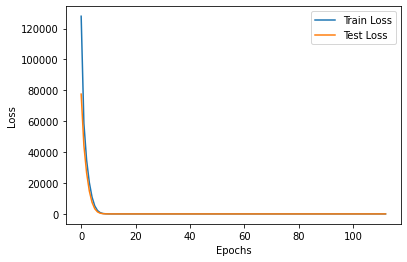

---------------------------------------------------------------------------------
Epoch : 113 / 500



Train Loss: 0.7012923613507697 | Train KL: 0.06798918677348617
Train Acc: [0.5125887  0.51165783 0.5040337  0.50633866 0.5030585  0.5083333
 0.52087766 0.5135638  0.5140071  0.4986259  0.51600176 0.52096635
 0.524867   0.5227394  0.5085993 ]
Test Loss: 0.7005950113137563 | Test KL: 0.06799288839101791
Test Acc: [0.5277778  0.53125    0.5026042  0.5060764  0.5303819  0.5234375
 0.49739584 0.49739584 0.5269097  0.4939236  0.5034722  0.5052083
 0.5225694  0.5017361  0.5052083 ]


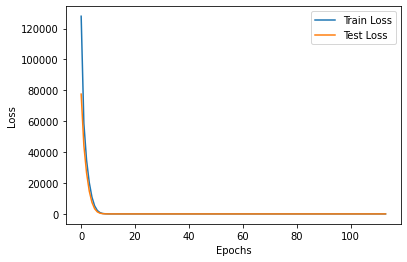

---------------------------------------------------------------------------------
Epoch : 114 / 500



Train Loss: 0.7004945903805131 | Train KL: 0.0679884894308469
Train Acc: [0.508555   0.53736705 0.5040337  0.5091312  0.5135638  0.5084663
 0.5025709  0.506383   0.5177305  0.5010638  0.5281915  0.5182181
 0.5117021  0.5132092  0.5177748 ]
Test Loss: 0.7017225027084351 | Test KL: 0.06798498332500458
Test Acc: [0.5173611  0.5078125  0.5425347  0.5095486  0.5434028  0.5069444
 0.4887153  0.5199653  0.5        0.5190972  0.4982639  0.47743055
 0.4904514  0.48958334 0.47743055]


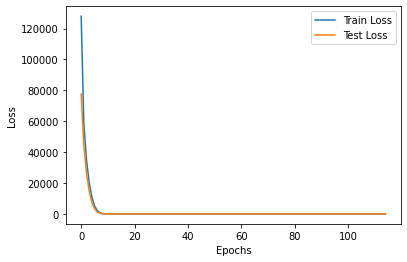

---------------------------------------------------------------------------------
Epoch : 115 / 500



Train Loss: 0.7011439419807272 | Train KL: 0.06797933541502513
Train Acc: [0.5203901  0.5153369  0.49742904 0.5082447  0.5059397  0.50474286
 0.5185284  0.50970745 0.52021277 0.5144504  0.51121455 0.51414007
 0.50514185 0.49906915 0.5008422 ]
Test Loss: 0.7028265131844414 | Test KL: 0.06797637790441513
Test Acc: [0.5190972  0.5225694  0.4809028  0.5260417  0.5234375  0.4809028
 0.48524305 0.5121528  0.5477431  0.5060764  0.5364583  0.47135416
 0.5121528  0.5086806  0.48524305]


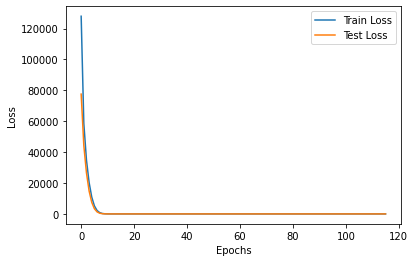

---------------------------------------------------------------------------------
Epoch : 116 / 500



Epoch   117: reducing learning rate of group 0 to 6.1035e-08.
Train Loss: 0.7012668057536402 | Train KL: 0.06797217435025155
Train Acc: [0.50093085 0.5192376  0.5022606  0.5149823  0.51959217 0.5261968
 0.5035018  0.5074912  0.51156914 0.5128989  0.51285464 0.51901597
 0.51099294 0.50873226 0.5017287 ]
Test Loss: 0.7021132873164283 | Test KL: 0.06797028332948685
Test Acc: [0.4982639  0.484375   0.5164931  0.48177084 0.4765625  0.5052083
 0.5095486  0.4956597  0.48177084 0.5251736  0.4921875  0.5078125
 0.5355903  0.5217014  0.4644097 ]


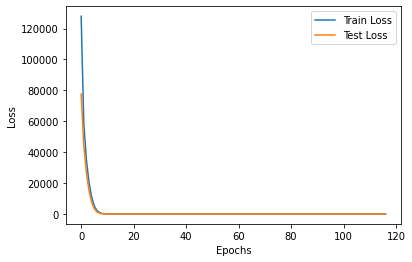

---------------------------------------------------------------------------------
Epoch : 117 / 500



Train Loss: 0.701370859399755 | Train KL: 0.06797108883764727
Train Acc: [0.51006204 0.49689716 0.5013741  0.49259755 0.5179078  0.5083333
 0.51613474 0.52101064 0.50372344 0.5278812  0.50669324 0.5153369
 0.51254433 0.51688826 0.49973404]
Test Loss: 0.7021000666750802 | Test KL: 0.06797342747449875
Test Acc: [0.5026042  0.5373264  0.48697916 0.5407986  0.515625   0.5555556
 0.4765625  0.49479166 0.4626736  0.5        0.5164931  0.5173611
 0.5295139  0.5069444  0.46875   ]


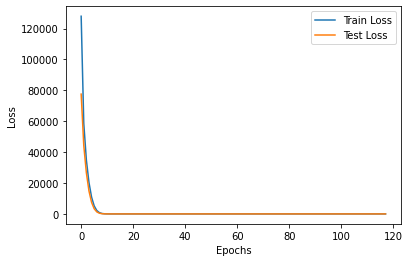

---------------------------------------------------------------------------------
Epoch : 118 / 500



Train Loss: 0.7009693333443175 | Train KL: 0.06797178480642062
Train Acc: [0.516578   0.5128103  0.50678194 0.49889183 0.51764184 0.5156915
 0.5086879  0.50602835 0.5129876  0.510461   0.5076241  0.51307625
 0.5079344  0.5167996  0.5140514 ]
Test Loss: 0.7016744083828397 | Test KL: 0.06797254085540771
Test Acc: [0.49479166 0.5329861  0.484375   0.4904514  0.5147569  0.49913195
 0.4921875  0.5121528  0.5381944  0.5147569  0.48958334 0.5086806
 0.5243056  0.5347222  0.46354166]


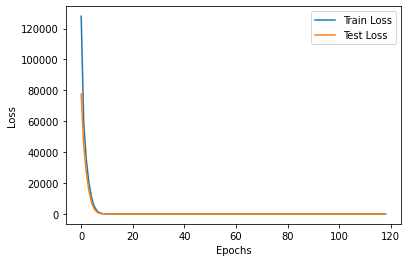

---------------------------------------------------------------------------------
Epoch : 119 / 500



Train Loss: 0.7011116404905386 | Train KL: 0.06797420709057057
Train Acc: [0.5087766  0.4944149  0.50372344 0.5062943  0.50691485 0.5079344
 0.5254876  0.5077128  0.5089983  0.5101064  0.5246454  0.50580674
 0.52087766 0.5152039  0.5046986 ]
Test Loss: 0.7011178268326653 | Test KL: 0.067975714802742
Test Acc: [0.5381944  0.5052083  0.48350695 0.5043403  0.49739584 0.5199653
 0.5520833  0.53125    0.5329861  0.5086806  0.4904514  0.5060764
 0.5104167  0.5164931  0.5043403 ]


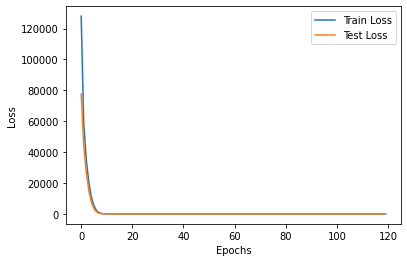

---------------------------------------------------------------------------------
Epoch : 120 / 500



Train Loss: 0.7011360982631115 | Train KL: 0.06797467837942407
Train Acc: [0.50057626 0.49618796 0.5228723  0.50895387 0.5132092  0.5143174
 0.52118796 0.5039007  0.5175532  0.51493794 0.5020833  0.52242905
 0.50536346 0.50882095 0.49078012]
Test Loss: 0.7009557104772992 | Test KL: 0.06797656416893005
Test Acc: [0.515625   0.484375   0.5060764  0.4644097  0.5303819  0.5008681
 0.5399306  0.5225694  0.5112847  0.4861111  0.5078125  0.5234375
 0.5052083  0.49739584 0.4809028 ]


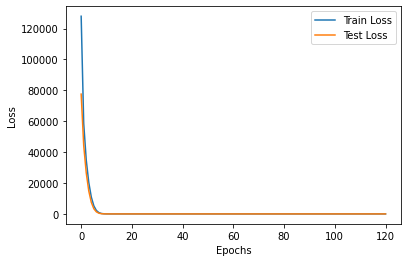

---------------------------------------------------------------------------------
Epoch : 121 / 500



Train Loss: 0.7007924749496135 | Train KL: 0.06797410637563002
Train Acc: [0.49831557 0.5199468  0.50939715 0.520656   0.5036791  0.51613474
 0.49179965 0.5095745  0.51374114 0.514672   0.5237588  0.50753546
 0.5164893  0.52708334 0.50101954]
Test Loss: 0.7010238981909223 | Test KL: 0.0679761990904808
Test Acc: [0.5052083  0.4904514  0.484375   0.5381944  0.5190972  0.5190972
 0.5260417  0.48524305 0.5182292  0.5112847  0.5052083  0.5260417
 0.5451389  0.5        0.49739584]


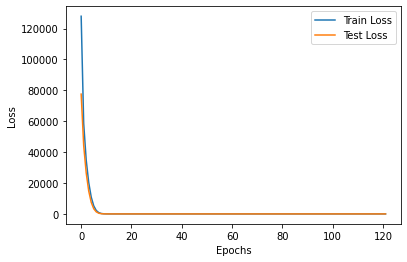

---------------------------------------------------------------------------------
Epoch : 122 / 500



Train Loss: 0.7012717064390791 | Train KL: 0.06797969943665444
Train Acc: [0.51414007 0.5204344  0.50585103 0.49406028 0.50159574 0.50372344
 0.50518614 0.5133865  0.5099734  0.5093528  0.508023   0.5184397
 0.5142287  0.50115246 0.5112589 ]
Test Loss: 0.7007060663567649 | Test KL: 0.06797981262207031
Test Acc: [0.5052083  0.5251736  0.5303819  0.5347222  0.48697916 0.5512153
 0.5225694  0.5        0.48177084 0.5104167  0.46180555 0.4939236
 0.4921875  0.5668403  0.5026042 ]


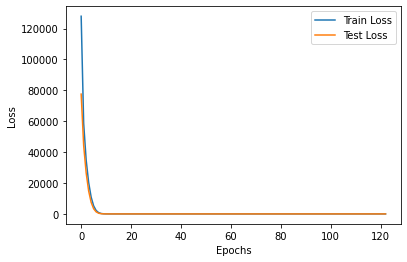

---------------------------------------------------------------------------------
Epoch : 123 / 500



Epoch   124: reducing learning rate of group 0 to 3.0518e-08.
Train Loss: 0.7006707766377334 | Train KL: 0.06797874766461393
Train Acc: [0.51644504 0.5142287  0.518883   0.5028369  0.5133422  0.50385636
 0.51156914 0.5135638  0.5083777  0.50904256 0.5178635  0.5159131
 0.51090425 0.516578   0.49738473]
Test Loss: 0.7020930416054196 | Test KL: 0.0679759606719017
Test Acc: [0.47569445 0.49913195 0.47395834 0.48697916 0.5112847  0.5338542
 0.5199653  0.5034722  0.5338542  0.48350695 0.5        0.5234375
 0.5130208  0.5225694  0.5026042 ]


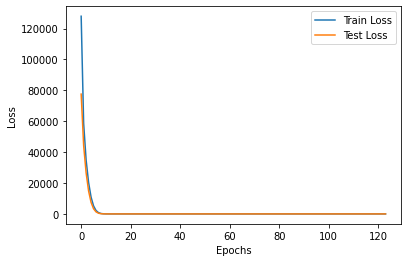

---------------------------------------------------------------------------------
Epoch : 124 / 500



Train Loss: 0.7012807553541576 | Train KL: 0.06797617996203983
Train Acc: [0.5116134  0.514672   0.502172   0.5035018  0.50328016 0.51436174
 0.52349293 0.51945925 0.52109927 0.5093528  0.5193262  0.5057181
 0.5071365  0.51546985 0.48914006]
Test Loss: 0.7000044302807914 | Test KL: 0.06797750294208527
Test Acc: [0.5225694  0.4921875  0.5208333  0.5355903  0.45399305 0.49739584
 0.5217014  0.4904514  0.5130208  0.5251736  0.5451389  0.5338542
 0.515625   0.48958334 0.5407986 ]


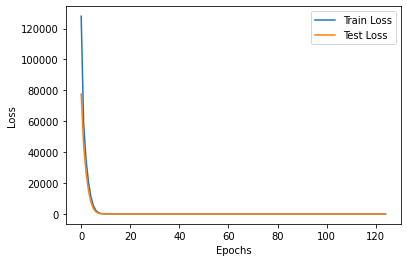

---------------------------------------------------------------------------------
Epoch : 125 / 500



Train Loss: 0.7014266489245368 | Train KL: 0.06797805449641342
Train Acc: [0.51015073 0.5035018  0.50691485 0.4992908  0.5070479  0.5078457
 0.5014628  0.50589544 0.50735813 0.5068263  0.5136525  0.5111702
 0.5084663  0.50372344 0.49703017]
Test Loss: 0.7017615603076087 | Test KL: 0.06797841936349869
Test Acc: [0.49305555 0.5286458  0.5173611  0.5104167  0.49913195 0.4982639
 0.4982639  0.5486111  0.49739584 0.4956597  0.4826389  0.47569445
 0.5017361  0.5199653  0.4652778 ]


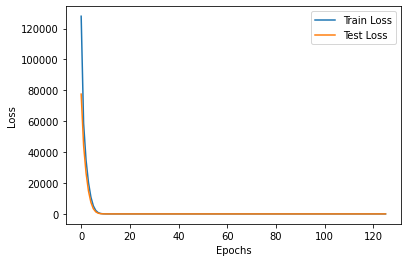

---------------------------------------------------------------------------------
Epoch : 126 / 500



Train Loss: 0.7013113447960387 | Train KL: 0.0679785448608669
Train Acc: [0.50549644 0.51427305 0.51054966 0.5015071  0.5136525  0.5159575
 0.51414007 0.5114805  0.50624996 0.51511526 0.5100177  0.5142287
 0.5147607  0.51360816 0.48111704]
Test Loss: 0.7014742808209525 | Test KL: 0.0679793506860733
Test Acc: [0.5329861  0.48177084 0.4809028  0.47916666 0.49305555 0.5121528
 0.4939236  0.5164931  0.5017361  0.5182292  0.5277778  0.5277778
 0.5364583  0.5260417  0.46006945]


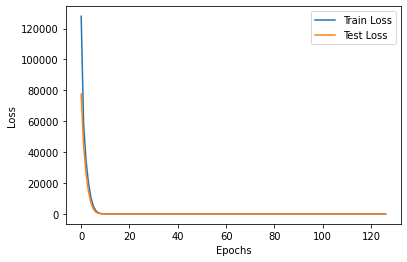

---------------------------------------------------------------------------------
Epoch : 127 / 500



Train Loss: 0.7011985520944528 | Train KL: 0.06797991217450892
Train Acc: [0.50039893 0.51609045 0.5212323  0.50460994 0.5156472  0.5083333
 0.5023936  0.51037234 0.5137854  0.51613474 0.5129876  0.50616133
 0.5144504  0.50992906 0.5019504 ]
Test Loss: 0.7000911749071546 | Test KL: 0.06798063218593597
Test Acc: [0.5477431  0.49305555 0.5243056  0.5321181  0.5329861  0.5147569
 0.5190972  0.5225694  0.5243056  0.5364583  0.5052083  0.5407986
 0.4921875  0.5303819  0.5138889 ]


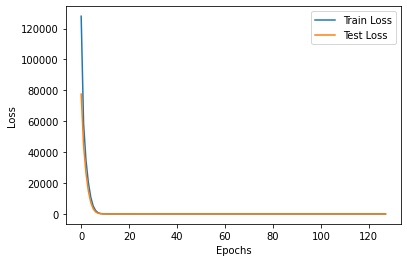

---------------------------------------------------------------------------------
Epoch : 128 / 500



Train Loss: 0.7018856600666723 | Train KL: 0.06798191194204574
Train Acc: [0.51542556 0.514672   0.5125887  0.508023   0.51090425 0.5078457
 0.5039007  0.4957447  0.48710108 0.5059397  0.51675534 0.5027039
 0.51436174 0.5092199  0.48891845]
Test Loss: 0.6998297588692771 | Test KL: 0.06798195838928223
Test Acc: [0.5355903  0.5442708  0.5538194  0.4826389  0.5225694  0.48177084
 0.4939236  0.5442708  0.5329861  0.5555556  0.5251736  0.5052083
 0.5095486  0.5        0.5208333 ]


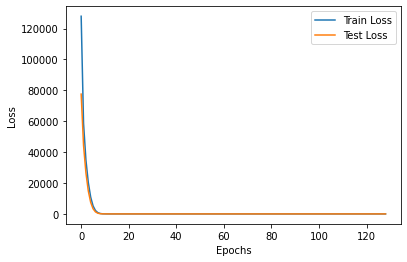

---------------------------------------------------------------------------------
Epoch : 129 / 500



Train Loss: 0.701538362824325 | Train KL: 0.06798194438641798
Train Acc: [0.50523055 0.5046986  0.4984929  0.48998228 0.5077128  0.5240692
 0.5144504  0.5057181  0.51391846 0.5056294  0.5195479  0.50904256
 0.5137854  0.5199911  0.4907358 ]
Test Loss: 0.7009110964006848 | Test KL: 0.06798231601715088
Test Acc: [0.5381944  0.4782986  0.5        0.5277778  0.5026042  0.48350695
 0.5251736  0.4748264  0.4730903  0.4782986  0.5217014  0.4982639
 0.5182292  0.5052083  0.5043403 ]


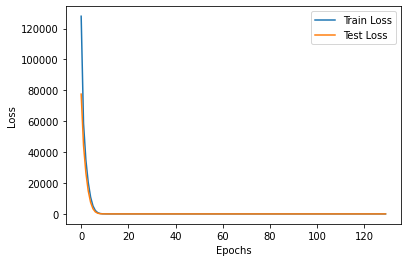

---------------------------------------------------------------------------------
Epoch : 130 / 500



Epoch   131: reducing learning rate of group 0 to 1.5259e-08.
Train Loss: 0.7012910208803542 | Train KL: 0.06798272743715462
Train Acc: [0.50815606 0.5069592  0.4930408  0.49773937 0.51742023 0.5129876
 0.50328016 0.51688826 0.5121011  0.50948584 0.51742023 0.5129876
 0.51812947 0.5022606  0.508289  ]
Test Loss: 0.7010037269857194 | Test KL: 0.06798277050256729
Test Acc: [0.5199653  0.5199653  0.5407986  0.515625   0.5581597  0.5043403
 0.46875    0.48697916 0.49479166 0.47135416 0.5052083  0.5225694
 0.5364583  0.5355903  0.47916666]


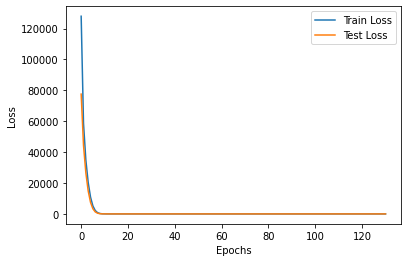

---------------------------------------------------------------------------------
Epoch : 131 / 500



Train Loss: 0.7016981096132427 | Train KL: 0.06798300464102562
Train Acc: [0.49694148 0.5240248  0.5031471  0.50580674 0.5034131  0.51134753
 0.50460994 0.5100177  0.4966312  0.50328016 0.514672   0.5072695
 0.518883   0.5263741  0.5002216 ]
Test Loss: 0.701937821176317 | Test KL: 0.06798355281352997
Test Acc: [0.46875    0.5182292  0.5112847  0.48350695 0.5338542  0.5017361
 0.5303819  0.5052083  0.4887153  0.5130208  0.5182292  0.5520833
 0.5026042  0.5078125  0.5303819 ]


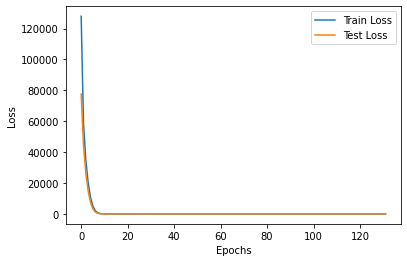

---------------------------------------------------------------------------------
Epoch : 132 / 500



Train Loss: 0.7005797066587083 | Train KL: 0.06798311851337446
Train Acc: [0.51990247 0.52251774 0.5049202  0.5130319  0.51103723 0.5223404
 0.5077128  0.5212323  0.50048757 0.51733154 0.50970745 0.5144504
 0.51223403 0.5246454  0.5074468 ]
Test Loss: 0.7025167644023895 | Test KL: 0.06798307597637177
Test Acc: [0.4861111  0.48958334 0.47135416 0.5199653  0.4861111  0.5190972
 0.49479166 0.5034722  0.4809028  0.5190972  0.5338542  0.5225694
 0.5251736  0.5078125  0.4800347 ]


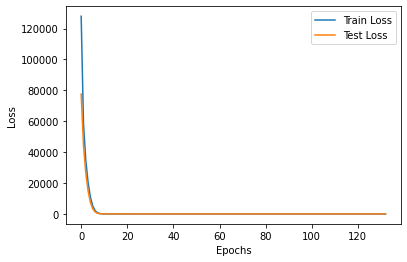

---------------------------------------------------------------------------------
Epoch : 133 / 500



Train Loss: 0.7008808834332947 | Train KL: 0.06798298413871873
Train Acc: [0.51427305 0.51945925 0.50265956 0.5078014  0.50115246 0.51586884
 0.5223404  0.5056294  0.52588654 0.5108156  0.51254433 0.5020833
 0.51099294 0.51471627 0.49352837]
Test Loss: 0.7019524988200929 | Test KL: 0.06798247247934341
Test Acc: [0.5217014  0.5251736  0.5321181  0.47916666 0.49305555 0.5269097
 0.5277778  0.5060764  0.515625   0.5138889  0.48697916 0.5043403
 0.5338542  0.49131945 0.4921875 ]


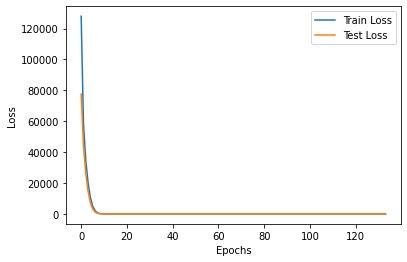

---------------------------------------------------------------------------------
Epoch : 134 / 500



Train Loss: 0.7010809791849014 | Train KL: 0.06798291528689945
Train Acc: [0.5135638  0.5171542  0.5093528  0.50545216 0.5026153  0.5091312
 0.50820035 0.50970745 0.5095745  0.5071365  0.5111702  0.51875
 0.51733154 0.5100177  0.49131206]
Test Loss: 0.702062812116411 | Test KL: 0.06798295676708221
Test Acc: [0.5112847  0.5164931  0.4748264  0.5338542  0.5286458  0.4800347
 0.515625   0.5381944  0.5008681  0.5052083  0.46961805 0.4652778
 0.5329861  0.5104167  0.5208333 ]


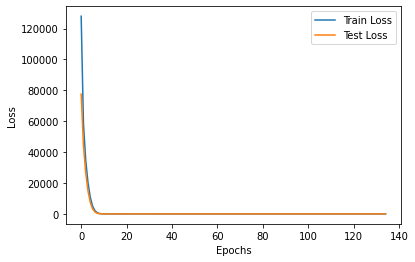

---------------------------------------------------------------------------------
Epoch : 135 / 500



Train Loss: 0.7015515003643983 | Train KL: 0.06798357574652272
Train Acc: [0.5055851  0.5071365  0.5059397  0.504078   0.51134753 0.5101064
 0.5137854  0.50678194 0.5244237  0.5        0.51312053 0.5195479
 0.5085993  0.5030585  0.49716312]
Test Loss: 0.7006528062952889 | Test KL: 0.06798417866230011
Test Acc: [0.4921875  0.4861111  0.4887153  0.5373264  0.5112847  0.5416667
 0.49913195 0.5234375  0.5321181  0.5121528  0.53125    0.5130208
 0.5329861  0.4782986  0.5190972 ]


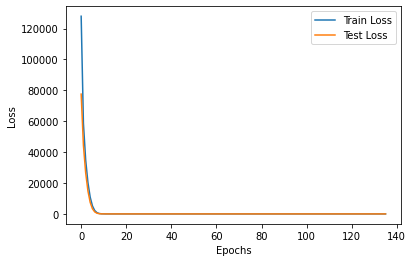

---------------------------------------------------------------------------------
Epoch : 136 / 500



Train Loss: 0.7012167670202594 | Train KL: 0.06798386499814107
Train Acc: [0.5225621  0.50536346 0.5121454  0.50097513 0.5001773  0.49982268
 0.51879436 0.50624996 0.51015073 0.518883   0.52477837 0.5020833
 0.51103723 0.51391846 0.49818262]
Test Loss: 0.7021049824025896 | Test KL: 0.06798379123210907
Test Acc: [0.5199653  0.5243056  0.48958334 0.48350695 0.48524305 0.4956597
 0.5034722  0.4800347  0.5225694  0.5199653  0.5338542  0.49479166
 0.49131945 0.5        0.5026042 ]


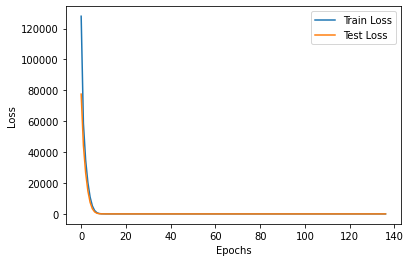

---------------------------------------------------------------------------------
Epoch : 137 / 500



Train Loss: 0.7009147004032812 | Train KL: 0.06798362462444509
Train Acc: [0.5173759  0.510594   0.50797874 0.5256649  0.5084663  0.510461
 0.50691485 0.50616133 0.5171986  0.5121011  0.5041224  0.5120124
 0.5113918  0.51600176 0.4941933 ]
Test Loss: 0.700710180732939 | Test KL: 0.06798341125249863
Test Acc: [0.5373264 0.5164931 0.515625  0.5078125 0.5095486 0.4921875 0.5251736
 0.5078125 0.4809028 0.5442708 0.5364583 0.5434028 0.5164931 0.5190972
 0.5190972]


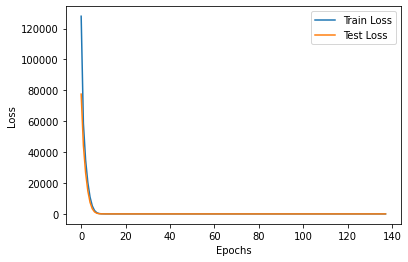

---------------------------------------------------------------------------------
Epoch : 138 / 500



Train Loss: 0.7015081014193542 | Train KL: 0.06798347413328522
Train Acc: [0.49654254 0.5026153  0.50806737 0.510461   0.5031915  0.5142287
 0.50797874 0.51586884 0.49773937 0.5039007  0.50992906 0.50460994
 0.50097513 0.5128103  0.495922  ]
Test Loss: 0.7010952350166109 | Test KL: 0.06798355281352997
Test Acc: [0.49479166 0.4670139  0.5017361  0.5164931  0.5451389  0.49479166
 0.5425347  0.5095486  0.4887153  0.4722222  0.5217014  0.5043403
 0.4956597  0.5069444  0.4904514 ]


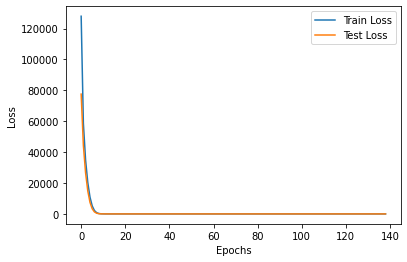

---------------------------------------------------------------------------------
Epoch : 139 / 500



Train Loss: 0.7013712157594397 | Train KL: 0.06798424561184349
Train Acc: [0.50372344 0.51968086 0.5060727  0.5133422  0.51121455 0.5035904
 0.50904256 0.5100177  0.5174646  0.50992906 0.50589544 0.5121454
 0.5226507  0.50097513 0.49924648]
Test Loss: 0.6999440987904867 | Test KL: 0.06798432767391205
Test Acc: [0.4800347  0.5321181  0.5303819  0.49479166 0.5017361  0.5286458
 0.5017361  0.5347222  0.5208333  0.5338542  0.49739584 0.5546875
 0.5052083  0.4982639  0.5555556 ]


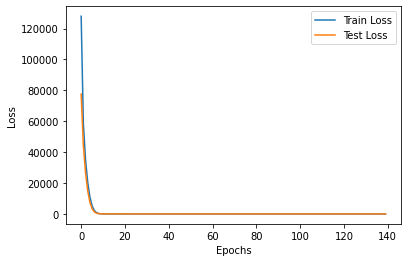

---------------------------------------------------------------------------------
Epoch : 140 / 500



Train Loss: 0.7012094817263015 | Train KL: 0.06798455658111166
Train Acc: [0.5148936  0.508023   0.52163124 0.50310284 0.5022606  0.524867
 0.5071365  0.49463654 0.5167996  0.50447696 0.5128989  0.5030585
 0.504078   0.49964538 0.49716312]
Test Loss: 0.7022306703858905 | Test KL: 0.06798480451107025
Test Acc: [0.5303819  0.5182292  0.4956597  0.4809028  0.484375   0.5208333
 0.5017361  0.5060764  0.48697916 0.5069444  0.49305555 0.5208333
 0.4861111  0.5069444  0.5130208 ]


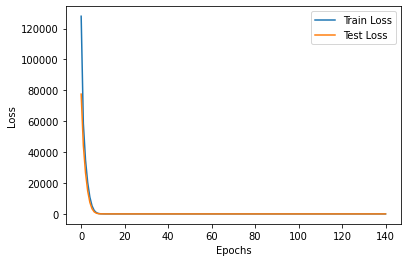

---------------------------------------------------------------------------------
Epoch : 141 / 500



Train Loss: 0.7014383267849049 | Train KL: 0.06798418088162199
Train Acc: [0.5127216  0.50624996 0.50093085 0.51436174 0.50159574 0.50031024
 0.52056736 0.50917554 0.51179075 0.5125887  0.51179075 0.5191046
 0.50806737 0.50580674 0.493617  ]
Test Loss: 0.7008562733729681 | Test KL: 0.06798436492681503
Test Acc: [0.5052083  0.49131945 0.5043403  0.5121528  0.5112847  0.5321181
 0.5104167  0.5217014  0.5416667  0.4722222  0.4878472  0.5277778
 0.48524305 0.5390625  0.5060764 ]


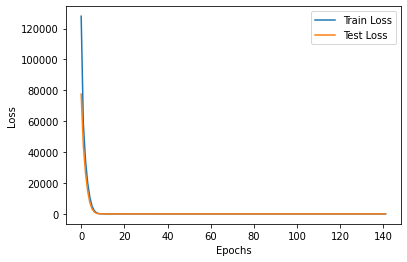

---------------------------------------------------------------------------------
Epoch : 142 / 500



Train Loss: 0.7015517117283868 | Train KL: 0.06798484921455383
Train Acc: [0.5191489  0.50181735 0.50647163 0.50895387 0.5222517  0.5074025
 0.5078014  0.5134752  0.5074025  0.5133422  0.5126773  0.50611705
 0.5085993  0.49020392 0.5026153 ]
Test Loss: 0.7012929121653239 | Test KL: 0.06798534095287323
Test Acc: [0.48350695 0.49479166 0.5425347  0.5416667  0.48697916 0.5277778
 0.4670139  0.4965278  0.5199653  0.5173611  0.5295139  0.5164931
 0.5451389  0.4982639  0.4626736 ]


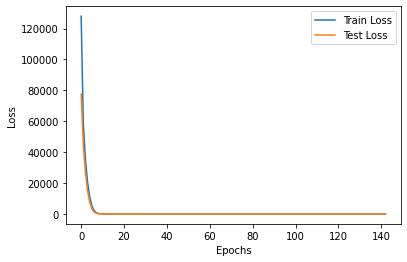

---------------------------------------------------------------------------------
Epoch : 143 / 500



Train Loss: 0.7006827389940302 | Train KL: 0.06798535469153248
Train Acc: [0.5062943  0.5156472  0.52012414 0.5007535  0.50806737 0.51023936
 0.5193262  0.5205231  0.51653373 0.51578015 0.5162677  0.50110817
 0.5100177  0.50328016 0.49100175]
Test Loss: 0.7002124653922187 | Test KL: 0.06798531115055084
Test Acc: [0.5130208 0.5182292 0.4956597 0.5190972 0.5303819 0.5321181 0.5095486
 0.4782986 0.5190972 0.5121528 0.53125   0.4956597 0.4809028 0.5034722
 0.53125  ]


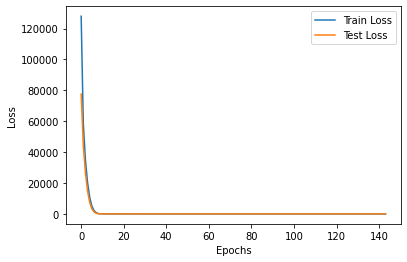

---------------------------------------------------------------------------------
Epoch : 144 / 500



Train Loss: 0.7010267495263552 | Train KL: 0.06798513027581762
Train Acc: [0.5115248  0.5107269  0.51312053 0.49751773 0.51037234 0.5113918
 0.5133422  0.51245564 0.5212323  0.5162234  0.5066046  0.5071365
 0.49840426 0.5132092  0.49042556]
Test Loss: 0.7019938876231512 | Test KL: 0.06798423826694489
Test Acc: [0.5095486  0.4861111  0.5190972  0.5112847  0.5034722  0.5008681
 0.4904514  0.4861111  0.5060764  0.5251736  0.4965278  0.4904514
 0.5121528  0.5147569  0.46006945]


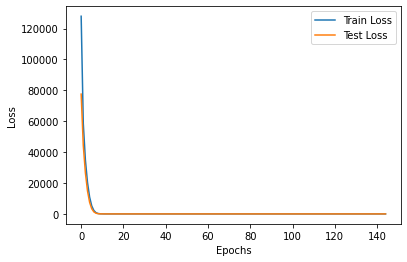

---------------------------------------------------------------------------------
Epoch : 145 / 500



Train Loss: 0.7011047846882056 | Train KL: 0.06798449776908184
Train Acc: [0.5174646  0.51515955 0.502039   0.5128103  0.49982268 0.50647163
 0.50093085 0.50416666 0.5038121  0.50048757 0.5066046  0.51937056
 0.5337766  0.5033688  0.5008422 ]
Test Loss: 0.7013089756170908 | Test KL: 0.06798473745584488
Test Acc: [0.5199653  0.4921875  0.4652778  0.5286458  0.5060764  0.5034722
 0.5416667  0.48958334 0.4956597  0.4722222  0.5130208  0.5373264
 0.48958334 0.5390625  0.49739584]


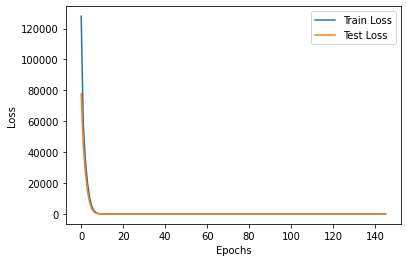

---------------------------------------------------------------------------------
Epoch : 146 / 500



Train Loss: 0.7011845809348086 | Train KL: 0.06798426896756422
Train Acc: [0.5098848  0.51631206 0.510594   0.49286348 0.50097513 0.51458335
 0.5026153  0.51710993 0.5089096  0.5091312  0.51710993 0.51524824
 0.5177748  0.5120124  0.51414007]
Test Loss: 0.7004470146364636 | Test KL: 0.0679849237203598
Test Acc: [0.5182292  0.5104167  0.49739584 0.4809028  0.49131945 0.5173611
 0.4956597  0.4956597  0.5503472  0.4956597  0.5338542  0.46788195
 0.5303819  0.5060764  0.5190972 ]


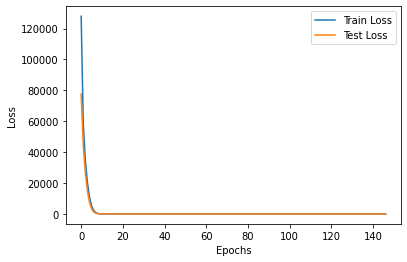

---------------------------------------------------------------------------------
Epoch : 147 / 500



Train Loss: 0.7013964902424643 | Train KL: 0.06798425285106009
Train Acc: [0.51312053 0.50904256 0.5159131  0.5074025  0.50039893 0.50549644
 0.5134752  0.5128103  0.5083777  0.50039893 0.51360816 0.49618796
 0.5092642  0.50895387 0.50008863]
Test Loss: 0.7007266531387965 | Test KL: 0.06798391044139862
Test Acc: [0.5199653  0.4982639  0.48958334 0.5347222  0.5130208  0.5147569
 0.4809028  0.546875   0.5052083  0.5208333  0.5451389  0.5286458
 0.5364583  0.5052083  0.5095486 ]


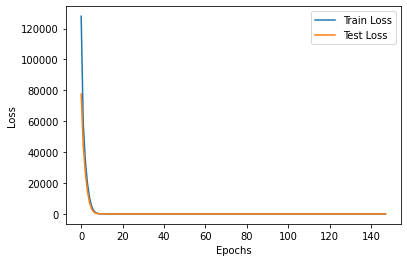

---------------------------------------------------------------------------------
Epoch : 148 / 500



Train Loss: 0.7013925364676942 | Train KL: 0.06798372629052359
Train Acc: [0.50115246 0.5133865  0.5172429  0.5041224  0.5089096  0.5126773
 0.51710993 0.506383   0.51644504 0.50611705 0.5153369  0.5008422
 0.5050532  0.50385636 0.4834663 ]
Test Loss: 0.7015386935737398 | Test KL: 0.0679842084646225
Test Acc: [0.5130208  0.5390625  0.5286458  0.49739584 0.5199653  0.5225694
 0.4826389  0.5060764  0.484375   0.5121528  0.4904514  0.5078125
 0.4644097  0.5130208  0.5251736 ]


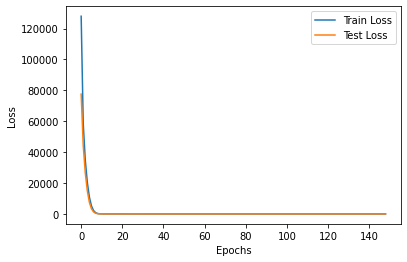

---------------------------------------------------------------------------------
Epoch : 149 / 500



Train Loss: 0.7014751683735678 | Train KL: 0.06798462157553815
Train Acc: [0.5214539  0.50616133 0.50296986 0.48129433 0.5171986  0.5119238
 0.50611705 0.5027926  0.50939715 0.4991578  0.51688826 0.5089096
 0.5134752  0.52101064 0.48789892]
Test Loss: 0.7016725987195969 | Test KL: 0.06798498332500458
Test Acc: [0.5069444 0.5182292 0.5086806 0.5121528 0.4939236 0.5034722 0.5112847
 0.5251736 0.5460069 0.4826389 0.5008681 0.5034722 0.5147569 0.5529514
 0.4956597]


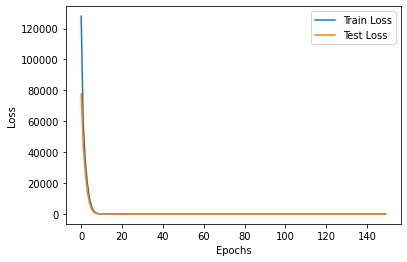

---------------------------------------------------------------------------------
Epoch : 150 / 500



Train Loss: 0.7015634229842652 | Train KL: 0.06798564130110098
Train Acc: [0.5074912  0.5134752  0.49751773 0.5186613  0.5176862  0.49818262
 0.5086436  0.49596632 0.51515955 0.5108156  0.5091312  0.5078014
 0.5089096  0.5221188  0.51032805]
Test Loss: 0.701132262746493 | Test KL: 0.06798607856035233
Test Acc: [0.5164931  0.5243056  0.47743055 0.5173611  0.5243056  0.5095486
 0.5399306  0.47395834 0.5060764  0.5390625  0.5277778  0.5199653
 0.4809028  0.5286458  0.5173611 ]


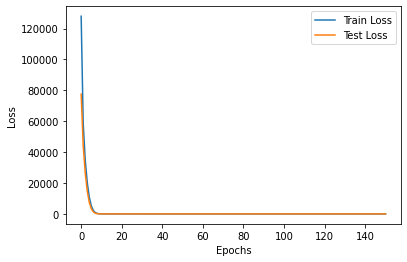

---------------------------------------------------------------------------------
Epoch : 151 / 500



Train Loss: 0.7009979790829598 | Train KL: 0.06798577144847694
Train Acc: [0.518484   0.5129876  0.5107713  0.5170213  0.50514185 0.51524824
 0.5045656  0.518883   0.51458335 0.5194149  0.49955675 0.51329786
 0.5028369  0.5281915  0.5012855 ]
Test Loss: 0.7001818898651335 | Test KL: 0.06798586994409561
Test Acc: [0.5060764 0.5260417 0.4965278 0.5173611 0.5295139 0.5043403 0.5043403
 0.5052083 0.5182292 0.5381944 0.5373264 0.5138889 0.5234375 0.5034722
 0.4956597]


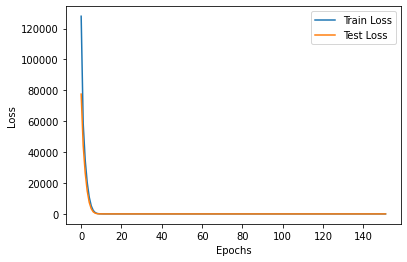

---------------------------------------------------------------------------------
Epoch : 152 / 500



Train Loss: 0.7014243425206935 | Train KL: 0.06798587411853439
Train Acc: [0.51099294 0.5226507  0.5098848  0.50691485 0.4956117  0.5046986
 0.5006206  0.51609045 0.5121454  0.5040337  0.5019504  0.51245564
 0.5177748  0.5119238  0.51037234]
Test Loss: 0.702506873342726 | Test KL: 0.06798640638589859
Test Acc: [0.5329861  0.5026042  0.4956597  0.5147569  0.5295139  0.5
 0.5251736  0.49305555 0.5069444  0.5208333  0.484375   0.5086806
 0.5130208  0.4921875  0.46006945]


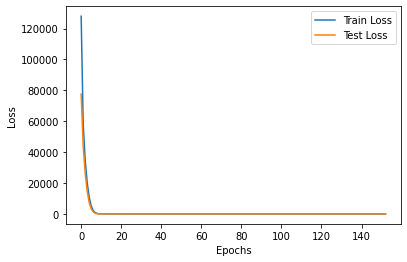

---------------------------------------------------------------------------------
Epoch : 153 / 500



Train Loss: 0.700909287371534 | Train KL: 0.06798513233661652
Train Acc: [0.50895387 0.5137854  0.5156915  0.50815606 0.5091312  0.51015073
 0.51875    0.52672875 0.5120124  0.5092642  0.50647163 0.51032805
 0.5233156  0.52070034 0.49906915]
Test Loss: 0.7028087245093452 | Test KL: 0.06798407435417175
Test Acc: [0.49305555 0.48350695 0.5251736  0.47743055 0.4826389  0.49131945
 0.5060764  0.5095486  0.5069444  0.4878472  0.5225694  0.5251736
 0.5243056  0.5338542  0.4826389 ]


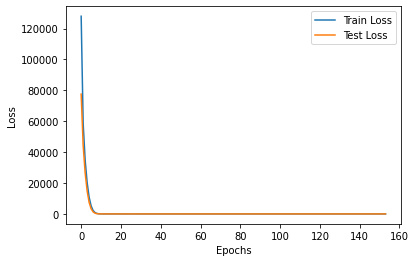

---------------------------------------------------------------------------------
Epoch : 154 / 500



Train Loss: 0.7014356488031699 | Train KL: 0.06798430706592316
Train Acc: [0.51546985 0.51329786 0.5095745  0.5057181  0.51037234 0.5057181
 0.51710993 0.51245564 0.51414007 0.5093085  0.5236259  0.5183511
 0.49503547 0.50549644 0.5001773 ]
Test Loss: 0.7003984997669855 | Test KL: 0.06798452138900757
Test Acc: [0.49913195 0.5217014  0.5052083  0.47395834 0.5104167  0.5008681
 0.5373264  0.5399306  0.5026042  0.48958334 0.5442708  0.5147569
 0.5295139  0.5104167  0.4748264 ]


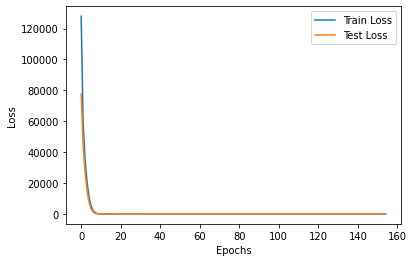

---------------------------------------------------------------------------------
Epoch : 155 / 500



Train Loss: 0.7015379718009461 | Train KL: 0.06798445528492014
Train Acc: [0.49707448 0.5086879  0.5049202  0.5085993  0.5045656  0.50633866
 0.51187944 0.5152039  0.49942374 0.51742023 0.5155585  0.5092642
 0.506383   0.50181735 0.49618796]
Test Loss: 0.7004460659292009 | Test KL: 0.0679846778512001
Test Acc: [0.49131945 0.4887153  0.5069444  0.5338542  0.5338542  0.49131945
 0.5347222  0.49913195 0.5095486  0.5329861  0.5329861  0.49913195
 0.4861111  0.5138889  0.46875   ]


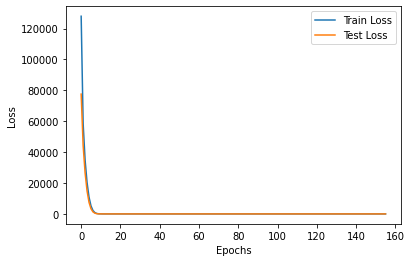

---------------------------------------------------------------------------------
Epoch : 156 / 500



Train Loss: 0.7013639173609145 | Train KL: 0.06798507775186646
Train Acc: [0.50624996 0.5180408  0.51165783 0.50514185 0.50540775 0.50886524
 0.51883864 0.51458335 0.5241135  0.5070479  0.51179075 0.5046542
 0.5049202  0.50177306 0.47823584]
Test Loss: 0.7001863718032837 | Test KL: 0.06798569858074188
Test Acc: [0.5416667  0.5208333  0.4965278  0.46788195 0.4956597  0.5017361
 0.5416667  0.5269097  0.5008681  0.5008681  0.515625   0.5381944
 0.5442708  0.5130208  0.5008681 ]


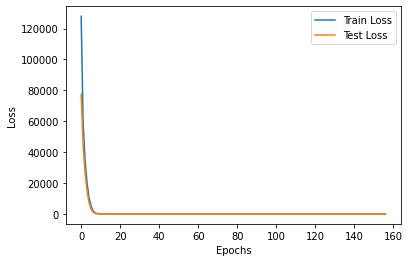

---------------------------------------------------------------------------------
Epoch : 157 / 500



Train Loss: 0.7013499428194465 | Train KL: 0.06798526359365341
Train Acc: [0.5000443  0.52508867 0.5042553  0.50394505 0.52012414 0.5131649
 0.52318263 0.5091312  0.5042553  0.50895387 0.51103723 0.49109045
 0.5172429  0.50159574 0.5045656 ]
Test Loss: 0.7008205321100023 | Test KL: 0.06798548996448517
Test Acc: [0.5017361  0.5269097  0.5182292  0.5017361  0.4921875  0.4904514
 0.49739584 0.5034722  0.5034722  0.5190972  0.5494792  0.5243056
 0.5347222  0.5069444  0.47916666]


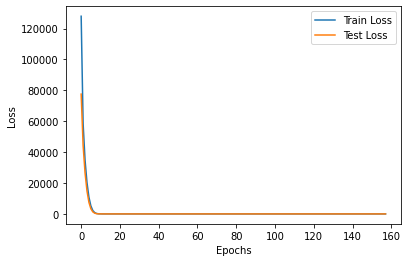

---------------------------------------------------------------------------------
Epoch : 158 / 500



Train Loss: 0.7005188579254962 | Train KL: 0.06798464778467272
Train Acc: [0.5094415  0.5085993  0.51879436 0.5077128  0.5152039  0.50438833
 0.50882095 0.508555   0.51945925 0.5175975  0.52220744 0.5172429
 0.50961876 0.5150266  0.50372344]
Test Loss: 0.7005318635039859 | Test KL: 0.06798449903726578
Test Acc: [0.5208333  0.4965278  0.5269097  0.4982639  0.5112847  0.5217014
 0.4921875  0.5        0.53125    0.5633681  0.5277778  0.5208333
 0.5182292  0.4748264  0.46614584]


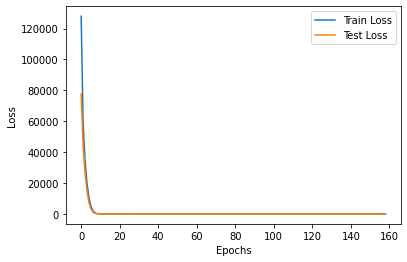

---------------------------------------------------------------------------------
Epoch : 159 / 500



Train Loss: 0.7007541339448158 | Train KL: 0.0679848699810657
Train Acc: [0.52034575 0.51223403 0.5121011  0.5101064  0.51037234 0.520789
 0.5156472  0.51524824 0.514406   0.50097513 0.5236259  0.508023
 0.51480496 0.49827126 0.51090425]
Test Loss: 0.7013561444150077 | Test KL: 0.06798528134822845
Test Acc: [0.5251736  0.5138889  0.5026042  0.48697916 0.5364583  0.4939236
 0.5104167  0.5251736  0.4904514  0.5008681  0.4565972  0.5069444
 0.5243056  0.5217014  0.49131945]


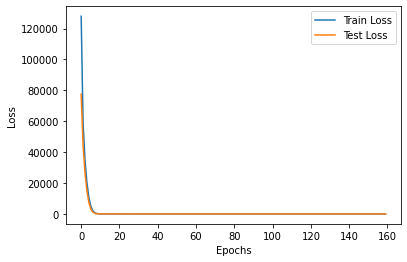

---------------------------------------------------------------------------------
Epoch : 160 / 500



Train Loss: 0.701464297923636 | Train KL: 0.06798553482649174
Train Acc: [0.50735813 0.51511526 0.5008422  0.50820035 0.50070924 0.52132094
 0.50580674 0.48945034 0.5149823  0.52730495 0.4921099  0.51112586
 0.50602835 0.52207446 0.50190604]
Test Loss: 0.7019429985019896 | Test KL: 0.06798554956912994
Test Acc: [0.5190972  0.4878472  0.5086806  0.4800347  0.4826389  0.5208333
 0.49739584 0.48697916 0.48177084 0.5425347  0.5008681  0.5104167
 0.5199653  0.5321181  0.5199653 ]


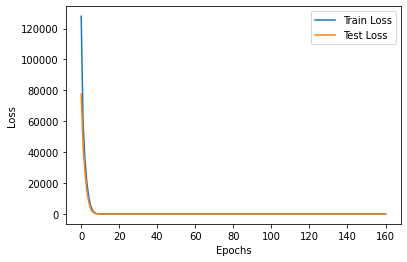

---------------------------------------------------------------------------------
Epoch : 161 / 500



Train Loss: 0.7015469551931882 | Train KL: 0.06798549841904471
Train Acc: [0.51812947 0.5075798  0.51391846 0.4965869  0.48723403 0.5108156
 0.5046542  0.51436174 0.49268618 0.5125     0.51449466 0.50970745
 0.51023936 0.5185284  0.516578  ]
Test Loss: 0.7006678150759803 | Test KL: 0.0679854303598404
Test Acc: [0.5269097  0.5147569  0.5095486  0.5217014  0.47916666 0.5104167
 0.5364583  0.5546875  0.48524305 0.484375   0.4921875  0.5390625
 0.5208333  0.5078125  0.5104167 ]


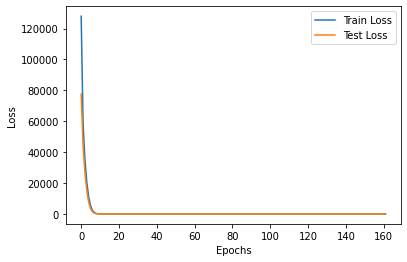

---------------------------------------------------------------------------------
Epoch : 162 / 500



Train Loss: 0.7011598293662916 | Train KL: 0.06798579485703868
Train Acc: [0.52557623 0.51901597 0.50181735 0.49973404 0.5200798  0.510461
 0.50611705 0.5070479  0.512367   0.5085106  0.5120567  0.5015071
 0.50775707 0.5029255  0.5059397 ]
Test Loss: 0.7027375300725301 | Test KL: 0.06798548996448517
Test Acc: [0.4878472  0.4748264  0.5182292  0.4887153  0.4965278  0.47135416
 0.5338542  0.5078125  0.5008681  0.49305555 0.5138889  0.4956597
 0.5008681  0.4965278  0.4878472 ]


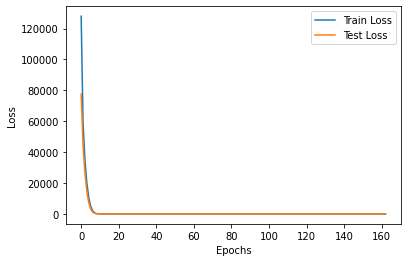

---------------------------------------------------------------------------------
Epoch : 163 / 500



Train Loss: 0.7018217524738176 | Train KL: 0.06798540193138393
Train Acc: [0.51094854 0.5079344  0.50904256 0.5010638  0.49840426 0.5022606
 0.50602835 0.5069592  0.52056736 0.51037234 0.51090425 0.5095745
 0.49671984 0.51600176 0.5034575 ]
Test Loss: 0.7005422992838753 | Test KL: 0.06798584759235382
Test Acc: [0.5390625  0.5373264  0.5112847  0.5086806  0.5078125  0.5651042
 0.4921875  0.5243056  0.5095486  0.5095486  0.5442708  0.5190972
 0.5295139  0.5173611  0.45833334]


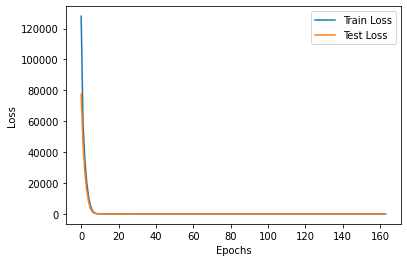

---------------------------------------------------------------------------------
Epoch : 164 / 500


KeyboardInterrupt: ignored

In [6]:
# Hyper Parameter settings
layer_type = 'lrt'
activation_type = 'relu'
priors = cfg.priors

train_ens = cfg.train_ens
valid_ens = cfg.valid_ens
n_epochs = 500
lr_start = cfg.lr_start
num_workers = cfg.num_workers
valid_size = cfg.valid_size
batch_size = cfg.batch_size
beta_type = cfg.beta_type

dataset = NIH_sample_dataset(datapath=datapath, labelpath=labelpath, transforms=list_transforms)
train_loader, test_loader = get_dataloader(dataset=dataset, test_size=0.2, batch_size=32, num_workers=70)

criterion = ELBO(len(train_loader)).to(device)
optimizer = Adam(model.parameters(), lr=0.001)
lr_sched = lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True, factor=0.5)

path = '/content/drive/My Drive/ISI/COVID-19/Bayesian_CNN/best_model_NIHsamplesData_state_dict.pt'
#model = get_model()
#model.load_state_dict(torch.load(path))

train_loss_list, test_loss_list = [], []

for epoch in range(n_epochs):  
    print('Epoch :',epoch,'/',n_epochs)

    train_loss, train_acc, train_kl = train_model(model, train_loader, optimizer, criterion, num_ens=train_ens, beta_type=beta_type, epoch=epoch, num_epochs=n_epochs)
    test_loss, test_acc, test_kl = validate_model(model, test_loader, criterion, num_ens=valid_ens, beta_type=beta_type, epoch=epoch, num_epochs=n_epochs)
    lr_sched.step(test_loss)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    print('Train Loss:',train_loss, '| Train KL:',train_kl)
    print('Train Acc:', train_acc)
    print('Test Loss:',test_loss,'| Test KL:',test_kl)
    print('Test Acc:', test_acc)

    torch.save(model.state_dict(), path)

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(train_loss_list, label='Train Loss')
    plt.plot(test_loss_list, label='Test Loss')
    plt.legend()
    plt.show()

    print('---------------------------------------------------------------------------------')